# DPX Calibration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import cPickle
import hickle
%matplotlib inline
%config InlineBackend.figure_format = 'png'

# Support functions
import dpx_func_python as su
import plotToTtoTHL as pttt
import plotTemperatureToT as pTT
import ToTtoEnergy as tte
import THLConversion as thlc

# Reload
reload(su), reload(pttt), reload(tte), reload(thlc), reload(pTT)

(<module 'dpx_func_python' from 'dpx_func_python.pyc'>,
 <module 'plotToTtoTHL' from 'plotToTtoTHL.pyc'>,
 <module 'ToTtoEnergy' from 'ToTtoEnergy.pyc'>,
 <module 'THLConversion' from 'THLConversion.pyc'>,
 <module 'plotTemperatureToT' from 'plotTemperatureToT.pyc'>)

## Input files

In [2]:
ToTDir = '../../dpx_data/Measurements'
# ToTfnList = [ToTDir + '/ToTMeasurement_AmSn4.hck'] 
ToTfnList = ['%s/DPX6/ToTMeasurement_%s.p' % (ToTDir, f) for f in ['AmSn2']] # , 'AmSn2']]
ToTHistFn = 'histMeasurement_AmSn.hck'
SLOT = 2
# ToTtoTHLfn = 'ToTtoTHL/DPX6/ToTtoTHL_5.hck'
ToTtoTHLfn = '../../dpx_data/ToTtoTHL_22.hck' # '../../dpx_data/ToTtoTHL/DPX22/ToTtoTHL_DPX22_2.hck'
# ToTtoTHLfn = 'ToTtoTHL_14.p'

## Convert ToT to THL

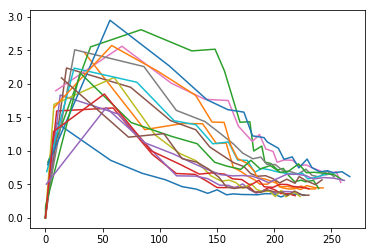

In [15]:
for i in range(16):
    ToT = d[3]['ToT'][i]
    ToTErr = d[3]['ToTErr'][i]
    # print ToT, ToTErr
    plt.plot(ToT, ToTErr)

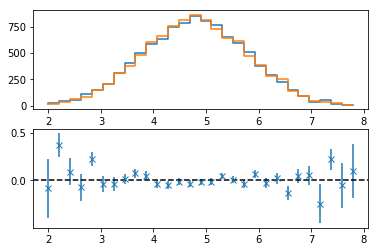

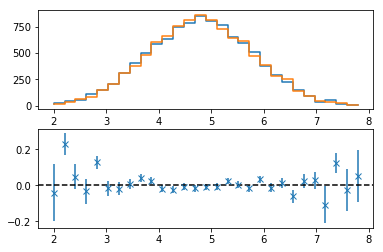

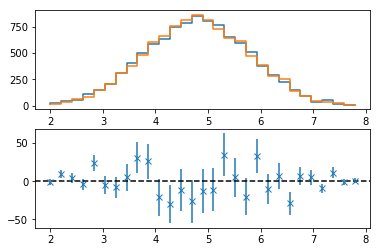

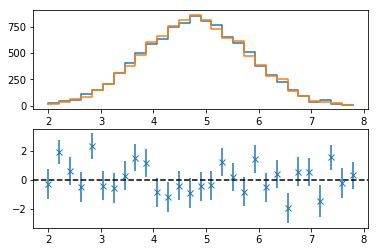

In [5]:
x = np.random.normal(5, 1, 10000)
bins = np.linspace(2, 8, 30)
hist, bins = np.histogram(x, bins=bins)
x = np.random.normal(5, 1, 10000)
hist2, bins2 = np.histogram(x, bins=bins)

hist, hist2 = np.asarray(hist, dtype=float), np.asarray(hist2, dtype=float)

fig, ax = plt.subplots(2, 1)
ax[0].step(bins[:-1], hist)
ax[0].step(bins[:-1], hist2)
ax[1].errorbar(bins[:-1], (hist - hist2)/hist, yerr=(hist2)/(hist**2)*np.sqrt(hist), marker='x', ls='')
ax[1].axhline(y=0, ls='--', c='k')
plt.show()

fig, ax = plt.subplots(2, 1)
ax[0].step(bins[:-1], hist)
ax[0].step(bins[:-1], hist2)
ax[1].errorbar(bins[:-1], (hist - hist2)/(hist + hist2), yerr=(2*hist2)/((hist + hist)**2)*np.sqrt(hist), marker='x', ls='')
ax[1].axhline(y=0, ls='--', c='k')
plt.show()

fig, ax = plt.subplots(2, 1)
ax[0].step(bins[:-1], hist)
ax[0].step(bins[:-1], hist2)
ax[1].errorbar(bins[:-1], hist - hist2, yerr=np.sqrt(hist), marker='x', ls='')
ax[1].axhline(y=0, ls='--', c='k')
plt.show()

fig, ax = plt.subplots(2, 1)
ax[0].step(bins[:-1], hist)
ax[0].step(bins[:-1], hist2)
ax[1].errorbar(bins[:-1], (hist-hist2)/np.sqrt(hist), yerr=(hist + hist2)/(2*hist**(1.5))*np.sqrt(hist), marker='x', ls='')
ax[1].axhline(y=0, ls='--', c='k')
plt.show()

plotToTtoTHL.py:38: RuntimeWarning: invalid value encountered in greater
  THLErr[THLErr > 100] = np.nan
plotToTtoTHL.py:143: RuntimeWarning: divide by zero encountered in divide
  res = np.where(x < b, a*(x - b) - c * (np.pi / 2 + t / (x - b)), 0)
plotToTtoTHL.py:72: RuntimeWarning: invalid value encountered in less_equal
  filtCond = THL_ <= 3000 # abs(THL_ - meanTHL) <= 3 * stdTHL


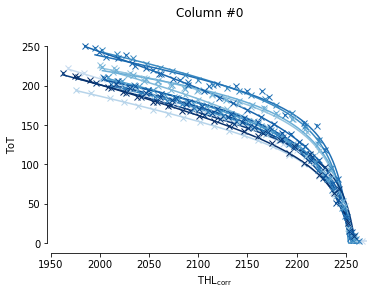

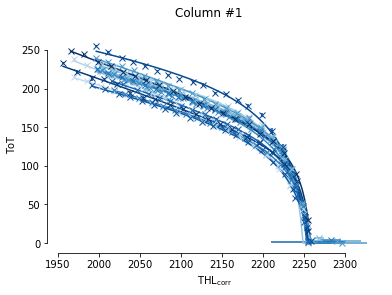

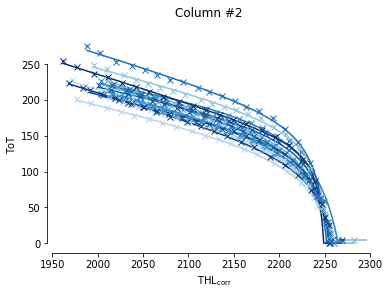

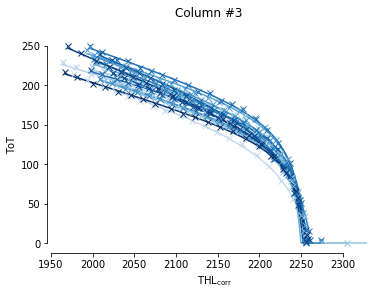

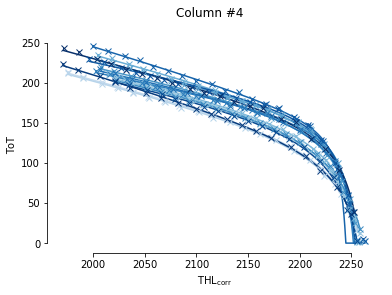

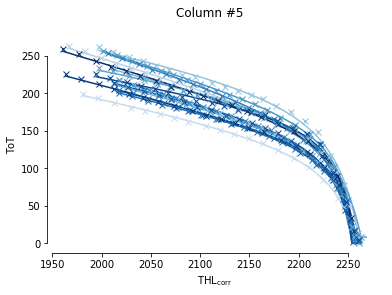

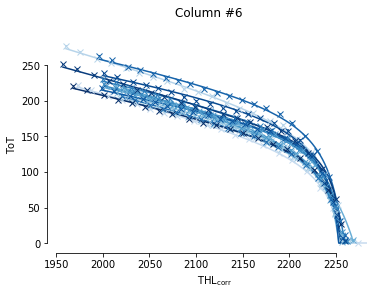

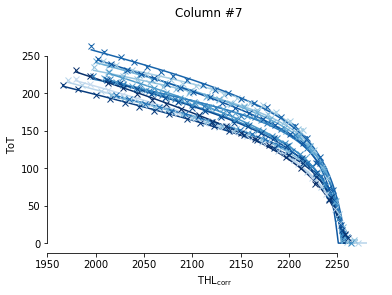

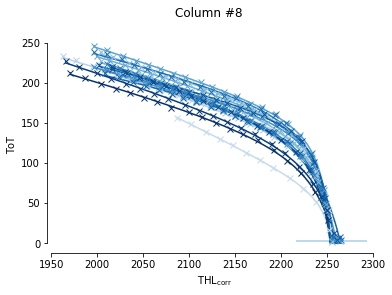

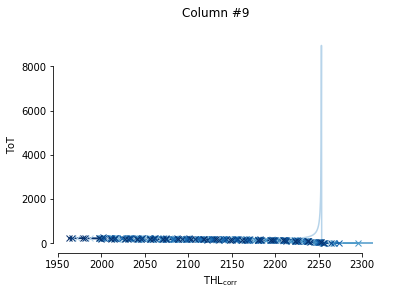

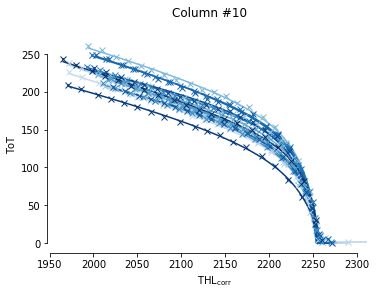

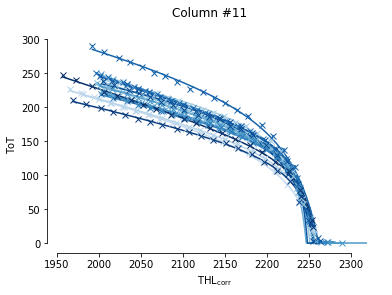

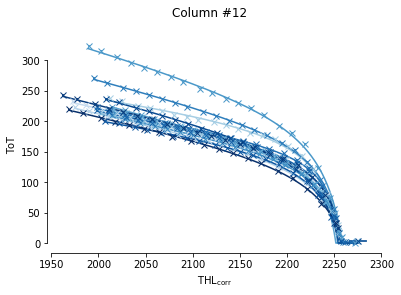

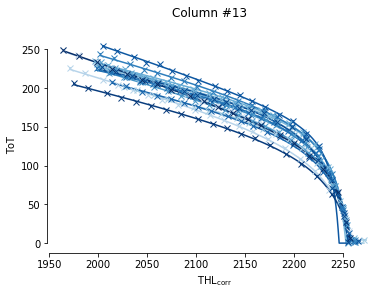

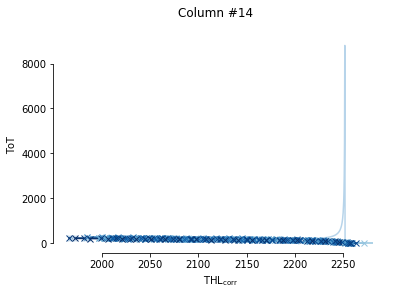

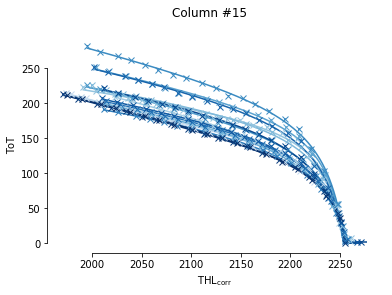

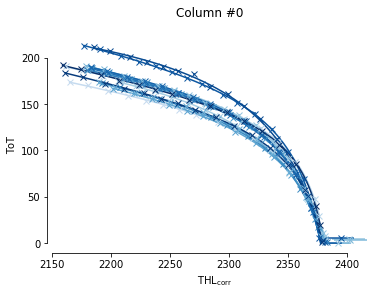

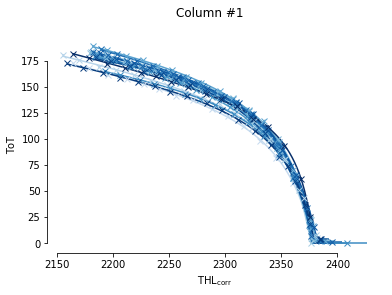

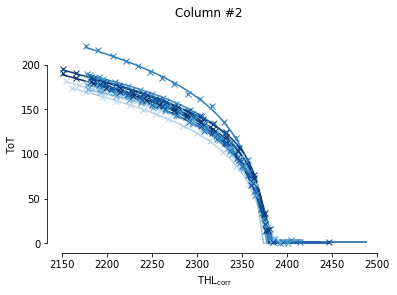

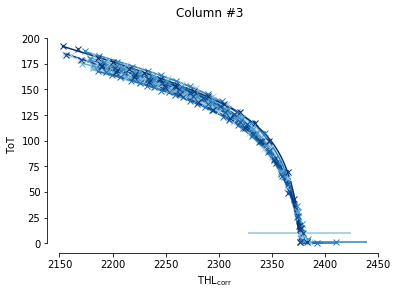

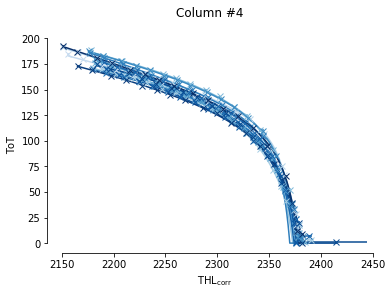

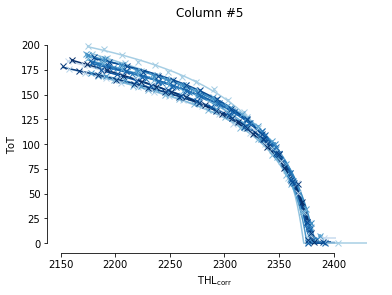

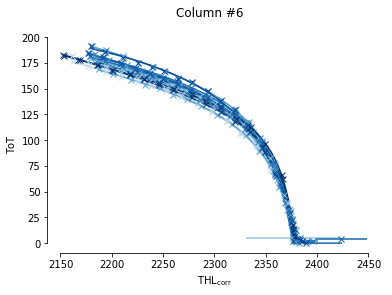

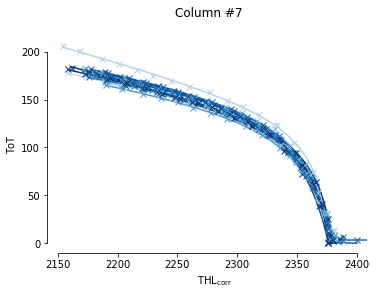

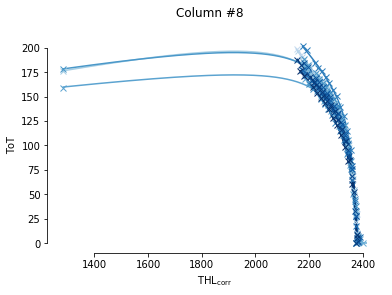

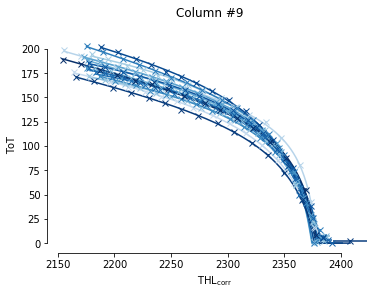

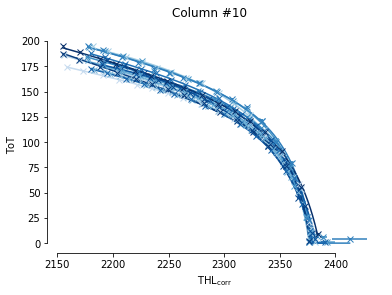

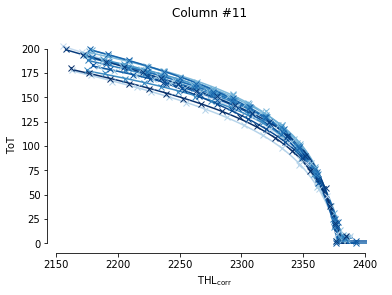

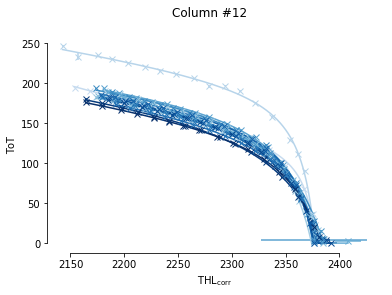

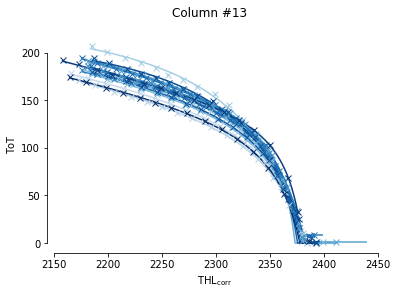

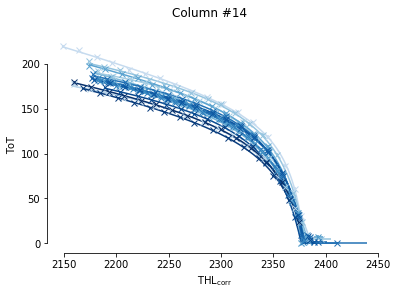

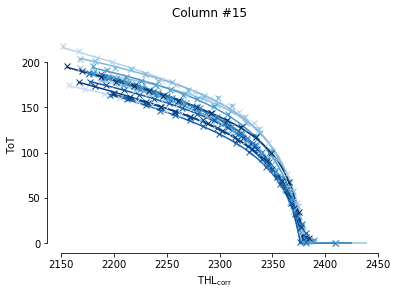

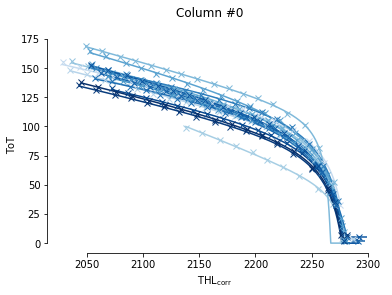

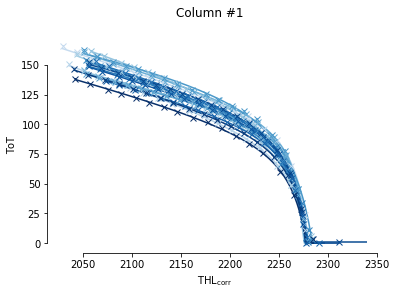

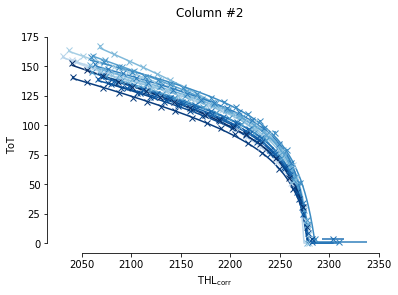

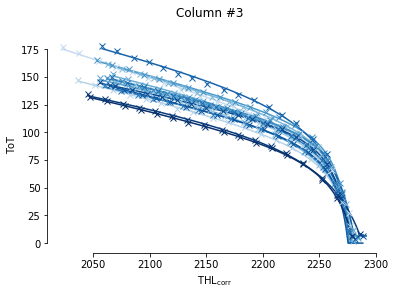

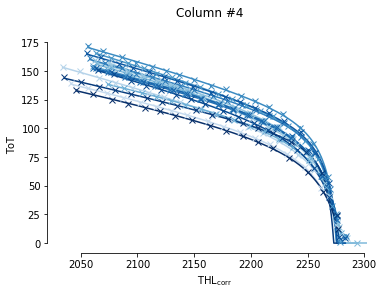

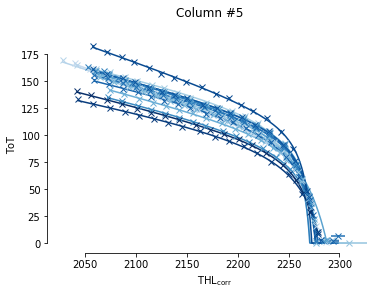

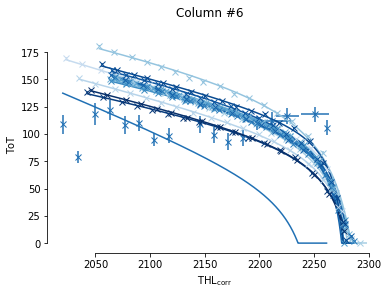

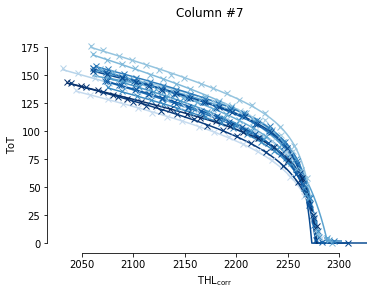

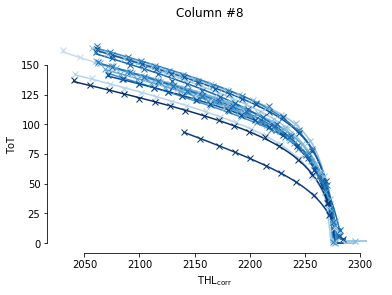

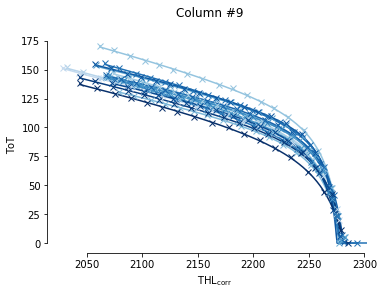

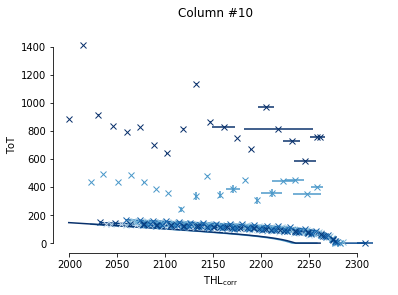

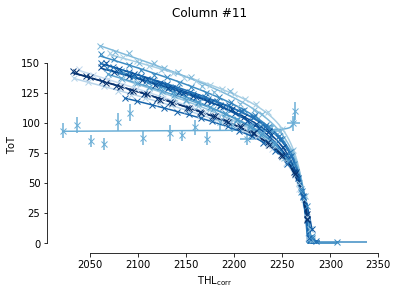

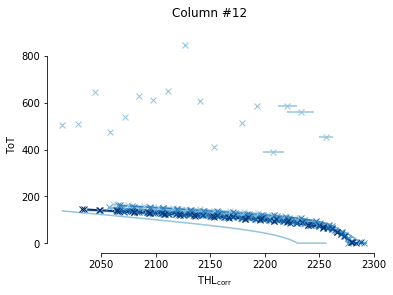

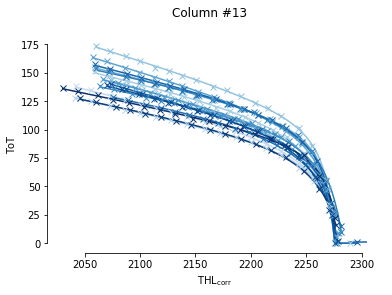

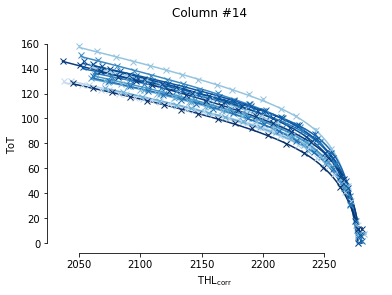

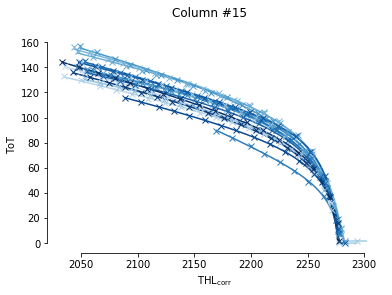

In [3]:
reload(pttt)

'''
# Load dictionary
if '.p' in ToTtoTHLfn:
    d = cPickle.load( open(ToTtoTHLfn, 'rb') )
else:
    d = hickle.load(ToTtoTHLfn)
    
paramsDict = hickle.load('../../dpx_data/energyConversion/paramsDict_DPX22.hck')
dOut = pttt.plotToTtoTHL(d, convDict=paramsDict) # , save='/tmp/')
'''

ToTtoTHLfnList = ['../../dpx_data/ToTtoTHL_%d.hck' % dpx for dpx in [22, 6, 109]] 
dOut = {'Slot%d' % (i + 1): pttt.plotToTtoTHL(hickle.load(ToTtoTHLfn), convDict=None) for i, ToTtoTHLfn in enumerate(ToTtoTHLfnList)}

## Load Spectrum

In [ ]:
dataList = [np.asarray( cPickle.load(open(ToTfn, 'r'))['Slot%d' % 2] ).T for ToTfn in ToTfnList]

In [ ]:
# Combine the data
data = np.hstack(dataList)
len(data), len(dataList[0])

## Convert data to histogram
Idea: Store data in ToT measurements in separate hickle files, containing a certain number of frames each. Afterwards, load them one after another and calculate the histogram for each file. Later, combine these histograms to get the data for the whole dataset. Therefore, the memory requirement is reduced drastically.

In [4]:
def dataToHist(data):
    histDict = {'bins': [], 'hist': []}
    for d in data:
        d = np.asarray(d)
        d = d[d > 0]
        try:
            hist, bins = np.histogram(d, bins=(max(d) - min(d)))
        except:
            hist, bins = None, None
            pass
        histDict['bins'].append(bins), histDict['hist'].append(hist)
        
    return histDict
    
# histDict = dataToHist(data)
# histDict = hickle.load('../../dpx_data/Measurements/DPX22/AmMo_DPX22_complete.hck')
# hickle.dump(histDict, open(ToTDir + '/ToTMeasurementHist_AmSn4.hck', 'w'))

## Convert multiple files to histogram

In [4]:
import scipy.signal

def dirToHist(directory, tempCalib=None, tempFile=None):
    cnt = len(os.listdir(directory))
    startTime = time.time()
    
    binsTot = [np.arange(4097)]*256
    histDict = {'Slot%d' % i: np.zeros((256, 4096)) for i in range(1, 3+1)}

    if tempCalib is not None:
        if tempFile is None:
            print 'Need temperature file when temperature calibration is requested!'
            return None
        else:
            tempDict = hickle.load(directory + '/' + tempFile)
            temperature = tempDict['temp']
            tempIdx = 0
            
            # Fit polynom to temperature data
            tempFilt = scipy.signal.savgol_filter(temperature, 1001, 3)
            # p = np.polyfit(np.arange(len(tempFilt)), tempFilt, 17)
            # tempFunc = np.poly1d(p)
            
            x = np.arange(len(tempFilt))
            plt.plot(x, temperature)
            plt.plot(x, tempFilt)
            plt.xlabel('Frame')
            plt.ylabel('Temperature (DAC)')
            plt.show()
    
    for c, fn in enumerate(sorted(os.listdir(directory))[:-1]):
        print fn
        if 'temp' in fn:
            continue
        print c
        # if c > cnt:
        #    break
            
        if fn.endswith('.hck'):
            data = hickle.load(directory + '/' + fn)
        elif fn.endswith('.p'):
            data = cPickle.load(open(directory + '/' + fn), 'rb')
        else:
            continue

        for slot in data.keys():
            slotData = np.asarray(data[slot]).T
            if tempCalib is not None:
                tempSlotCalib = tempCalib[slot]
            
            for pixel in range(256):
                pixelData = slotData[pixel]
                                
                # Filter empty entries
                pixelData = pixelData[pixelData > 0]

                if tempCalib is not None:
                    pixelData = np.asarray([pTT.getRealToT(pixelData[i], tempFilt[tempIdx + i], tempSlotCalib['Toffset'], tempSlotCalib['slope'][pixel], tempSlotCalib['offset'][pixel]) for i in range(len(pixelData))])
                    pixelData = pixelData[~np.isnan(pixelData)]

                hist, bins = np.histogram(pixelData, bins=binsTot[pixel])
                histDict[slot][pixel] += hist
                
        if tempCalib is not None:
            tempIdx += len(pixelData)
            
        print 'Estimated time: %.2f min' % (((time.time() - startTime) / (c + 1) * (cnt - c)) / 60)
            
    # for i in range(256):
    #    bins, hist = binsTot[i], histTot[i]
    #    bins[:-1] = bins[:-1][hist > 0]
    #    hist = hist[hist > 0]
        
    return {'Slot%d' % i: {'bins': binsTot, 'hist': histDict['Slot%d' % i]} for i in range(1, 3+1)}
    
# Load temperature calibration
# tempCalib = {'Slot%d' % (i + 1): hickle.load('tempCalib_DPX%d.hck' % num) for i, num in enumerate([22, 6, 109])}
testDict = dirToHist('/media/solvalou/58B9EB601FC22312/ToTMeasurement_AmIkrum120', tempCalib=None) # tempFile='ToTMeasurement25temp_96.hck')
# testDict2 = dirToHist('/media/solvalou/58B9EB601FC22312/DPX22_6_109/ToTMeasurement_25', tempCalib=None, tempFile=None)
# testDict = dirToHist('../../dpx_data/ToTMeasurement_13/', tempCalib=None, tempFile=None)

ToTMeasurement34temp_51.hck
ToTMeasurement_34.hck
1
Estimated time: 4.55 min
ToTMeasurement_35.hck
2
Estimated time: 5.66 min
ToTMeasurement_36.hck
3
Estimated time: 6.20 min
ToTMeasurement_37.hck
4
Estimated time: 6.36 min
ToTMeasurement_38.hck
5
Estimated time: 6.46 min
ToTMeasurement_39.hck
6
Estimated time: 6.49 min
ToTMeasurement_40.hck
7
Estimated time: 6.45 min
ToTMeasurement_41.hck
8
Estimated time: 6.40 min
ToTMeasurement_42.hck
9
Estimated time: 6.34 min
ToTMeasurement_43.hck
10
Estimated time: 6.24 min
ToTMeasurement_44.hck
11
Estimated time: 6.14 min
ToTMeasurement_45.hck
12
Estimated time: 6.03 min
ToTMeasurement_46.hck
13
Estimated time: 5.91 min
ToTMeasurement_47.hck
14
Estimated time: 5.79 min
ToTMeasurement_48.hck
15
Estimated time: 5.66 min
ToTMeasurement_49.hck
16
Estimated time: 5.53 min
ToTMeasurement_50.hck
17
Estimated time: 5.40 min
ToTMeasurement_51.hck
18
Estimated time: 5.26 min
ToTMeasurement_52.hck
19
Estimated time: 5.12 min
ToTMeasurement_53.hck
20
Estima

In [7]:
testDict['Slot1']['hist']
hickle.dump(testDict, open('../../dpx_data/AmIkrum.hck', 'w'))

In [5]:
# hickle.dump(testDict, open('../../dpx_data/Measurements/DPX22/Am_uncalib.hck', 'w'))
# hickle.dump(testDict, open('../../dpx_data/Measurements/AmMo_DPX22_6_109.hck', 'w'))
testDict = hickle.load('../../dpx_data/Measurements/AmMo_DPX22_6_109.hck')

## Load histograms from file

In [21]:
# histDict = hickle.load(ToTDir + '/DPX6/%s' % ToTHistFn)
# histDict2 = hickle.load('../../dpx_data/Measurements/DPX22/AmMo_DPX22_50.hck')
histDict2 = hickle.load('../../dpx_data/Measurements/DPX22/Am_wTemp_DPX22.hck')
# histDict = hickle.load('../../dpx_data/Measurements/DPX6/histMeasurement_AmSn.hck')
# histDict = hickle.load('../../dpx_data/ToTMeasurement_7_total.hck')
histDict = testDict
# histDict2 = testDict2

## Show examples

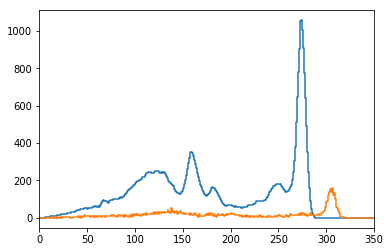

In [22]:
import scipy.signal

# idx = 20
slot = 'Slot1'
for idx in [3]: # range(3, 14):
    bins, hist = histDict[slot]['bins'][idx], histDict[slot]['hist'][idx]
    hist = hist[bins[:-1] < 350]
    bins = bins[bins < 350]

    plt.step(bins, scipy.signal.savgol_filter(hist, 11, 3), where='post')

plt.xlim(0, 350)

bins, hist = histDict2['bins'][idx], histDict2['hist'][idx]
hist = hist[bins[:-1] < 350]
bins = bins[bins < 350]
plt.step(bins, hist, where='post')
plt.show()

## Get conversion parameters for THL to energy

In [9]:
reload(thlc)
# paramsDict = thlc.THLConversion(histDict, dOut, plot=False, use_hist=True)
paramsDict = {'Slot%d' % i: thlc.THLConversion(histDict['Slot%d' % i], dOut['Slot%d' % i], plot=False, use_hist=True) for i in range(1, 3 + 1)}

[2178.64635402 1850.02373121] [ 340.17249417 1187.32400932]
[2181.43230366 1773.63230144] [ 351.44755245 1056.77156177]
[2173.99805106 1849.82803694] [ 333.004662   1067.55477855]
[2184.32417308 1682.2135611 ] [ 342.64335664 1110.26107226]
[2163.91360522 1777.307874  ] [ 363.50582751 1124.2960373 ]
[2166.55763483 1819.15279704] [ 332.84848485 1149.77389277]
[2190.8937857  1847.16841742] [317.67832168 983.67832168]
[2167.25310254 1817.9958948 ] [ 384.65268065 1222.16783217]
[2195.14736448 1791.80974221] [331.52447552 949.96969697]
[2174.48402484 1892.26215648] [222.57342657 739.89277389]
[2168.69399145 1760.49955911] [ 396.68764569 1178.68764569]
[2166.00126293 1798.37304082] [ 376.94172494 1180.5967366 ]
[2176.4946792 1770.7554412] [ 323.61538462 1002.24708625]
[2167.26796792 1840.3044161 ] [ 320.3962704  1048.83916084]
[2172.58182224 1831.00305172] [ 338.85547786 1060.51748252]
[2167.67257802 1823.89998018] [ 353.91142191 1075.61538462]
[2167.07633986 1804.58074382] [328.17948718 981.

[2159.75091558 1827.96124004] [ 348.80885781 1142.47785548]
[2167.5089895  1856.37149023] [331.23310023 917.77855478]
[2180.79779787 1847.84785612] [295.17016317 804.26573427]
[2172.84634193 1867.70299168] [323.61305361 968.12354312]
[2168.43899706 1788.19292356] [ 338.17016317 1027.23310023]
[2185.87986489 1801.77931045] [325.56643357 976.49417249]
[2165.75131299 1836.4906043 ] [ 367.92540793 1089.96037296]
[2161.20058373 1818.83553235] [ 361.58974359 1182.34965035]
[2174.89952059 1859.32844806] [ 332.49184149 1117.47319347]
[2170.3883408  1875.87059641] [ 317.42191142 1054.03496503]
[2154.6812756  1842.54967368] [250.69230769 824.67365967]
[2172.69324485 1846.4949482 ] [ 366.50582751 1176.26806527]
[2178.67841839 1876.65243309] [309.36363636 861.51981352]
[2164.76293682 1826.71814268] [ 367.65967366 1128.17948718]
[2161.54676986 1803.60213345] [ 370.20979021 1110.44988345]
[2163.33021238 1812.92294503] [ 402.5034965  1230.67599068]
[2169.79929763 1879.89482889] [ 334.98601399 1004.60

THLConversion.py:250: RuntimeWarning: invalid value encountered in sqrt
  return b + 1./(4 * a) * (2*x + np.pi*c + np.sqrt(16*a*c*t + (2*x + np.pi*c)**2))
THLConversion.py:88: RuntimeWarning: invalid value encountered in greater
  hist = hist[bins[:-1] > 0]
THLConversion.py:89: RuntimeWarning: invalid value encountered in greater
  bins = bins[bins > 0]
THLConversion.py:170: RuntimeWarning: divide by zero encountered in double_scalars
  slope = (energyList[0] - energyList[1]) / (THLList[0] - THLList[1])
THLConversion.py:190: RuntimeWarning: invalid value encountered in add
  bins = slope*np.asarray(bins) + offset


[2323.02659717 2272.43415443] [141.11888112 303.50582751]
[2269.64550736 1878.4701498 ] [293.46620047 648.60839161]
[2266.70667085 1777.46047445] [282.15850816 592.20979021]
[2265.67357919 1678.99204929] [286.70862471 658.84848485]
[2265.88736253 1865.32065133] [291.11421911 593.81818182]
[2275.15871949 1783.00014335] [272.71095571 540.46153846]
[2272.7816155  1757.57241555] [299.93939394 575.38228438]
[2286.02105707 1793.64880102] [271.75757576 448.21445221]
[2282.13034131 1901.44984046] [279.38927739 586.28671329]
[2269.58119875 1628.37161078] [290.71561772 573.36363636]
[2278.82314281 1878.02310948] [308.01165501 579.22843823]
[2273.98460427 1226.29535916] [286.25407925 574.82750583]
[2278.16050396 1782.93880122] [307.22377622 590.07459207]
[2270.15910566 1830.96091051] [313.81585082 643.88578089]
[2269.08024741 1781.85098578] [326.54312354 676.10722611]
[2266.65567655 1841.51596823] [301.66200466 646.30769231]
[2267.00314673 1785.27930075] [300.36829837 578.8041958 ]
[2269.29376811

[2277.51343753 1897.86486538] [296.82517483 624.30769231]
[2278.99432529 1925.76398814] [262.25407925 545.10722611]
[2274.59420256 1838.45232246] [294.36596737 628.85547786]
[2277.39961772 1813.40866728] [293.64801865 636.4009324 ]
[2277.98069773 1770.10095977] [297.2983683  610.12121212]
[2268.72625885 1770.54814005] [297.91142191 596.80885781]
[2276.00337971 1892.98468069] [314.42191142 618.79487179]
[2277.65318669 1790.69928334] [309.71328671 597.44522145]
[2281.7467861  1849.53515586] [317.18648019 643.37529138]
[2277.39668158 1815.78932099] [323.88344988 636.54778555]
[2371.78607151 1672.98908724] [397.58741259 616.44988345]
[2287.98215711 1860.97151483] [274.6993007  579.50582751]
[2275.84388679 1848.14637514] [289.14685315 605.96037296]
[2266.14530504 1926.05791547] [292.5034965 602.8997669]
[2281.84367901 1841.21108273] [299.81118881 601.18881119]
[2276.43973192 1839.95696668] [282.02564103 588.47552448]
[2278.45876286 1927.78066567] [302.28671329 570.8951049 ]
[2272.34871101 1

THLConversion.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  mean = 1./np.sum(hist) * np.dot(hist, bins[:-1])
THLConversion.py:68: RuntimeWarning: invalid value encountered in double_scalars
  mean = 1./np.sum(hist) * np.dot(hist, bins[:-1])


[2189.90052705 1832.25432509] [242.74125874 542.1958042 ]
[2193.41192025 1842.6565781 ] [246.82517483 507.3006993 ]
[2198.72350373 1761.98203649] [344.6013986  583.31235431]
[2198.97632778 1858.0026919 ] [270.59440559 524.27738928]
[2191.13588965 1866.51573693] [268.94871795 564.09090909]
[2190.67815633 1854.36993021] [283.86480186 560.94172494]
[2188.0600266  1427.26507712] [288.61538462 602.8974359 ]
[2194.92175553 1831.80888006] [273.41724942 594.54545455]
[2193.83847021 1849.59269527] [273.87645688 613.24242424]
[2189.018584   1833.75457249] [262.06759907 561.58508159]
[2190.37727971 1862.40424262] [278.70862471 609.96270396]
[2186.36542145 1835.69021695] [268.5967366  565.50815851]
[2191.94301911 1854.81220504] [268.8018648  598.81118881]
[2194.10242014 1830.05462732] [271.65501166 555.5967366 ]
[2188.73645221 1873.13384748] [269.8997669  564.41958042]
[2186.69682069 1848.42601146] [287.1025641  576.66433566]
[2182.49586999 1829.67665708] [292.92307692 593.44055944]
[2185.8608951 

## ToT to Energy
Use found conversion parameters on data

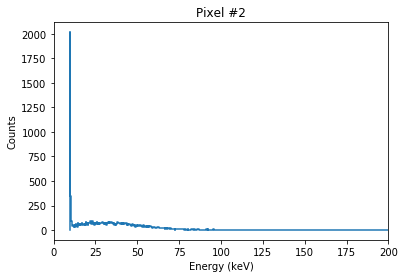

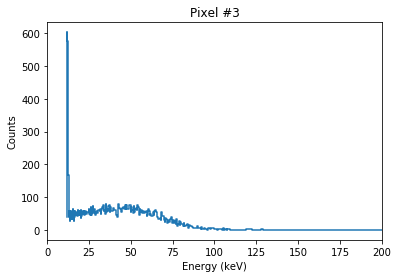

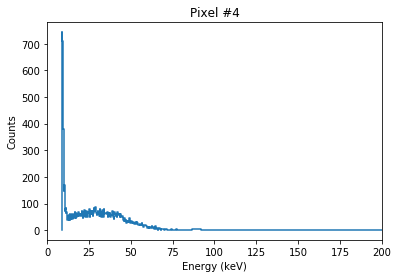

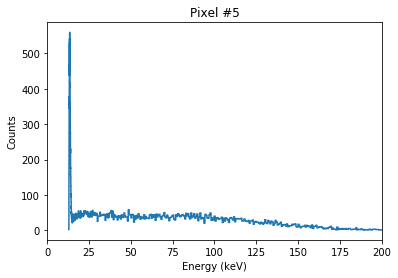

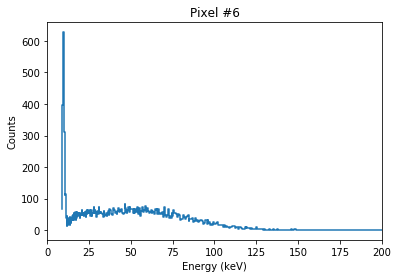

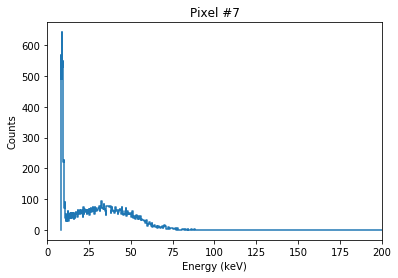

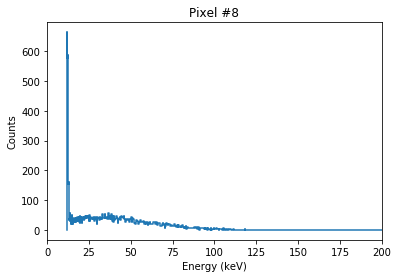

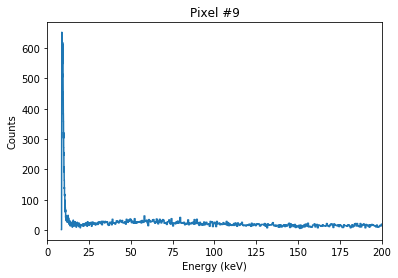

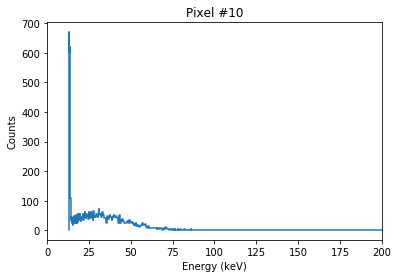

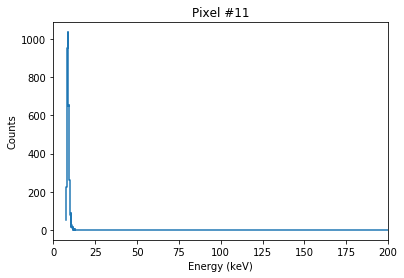

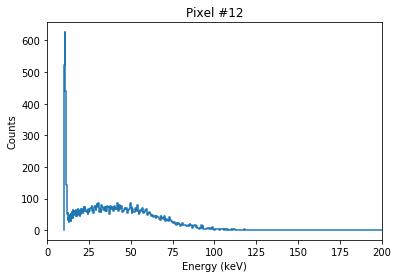

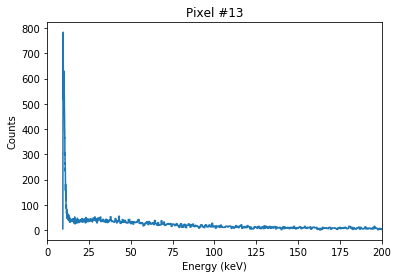

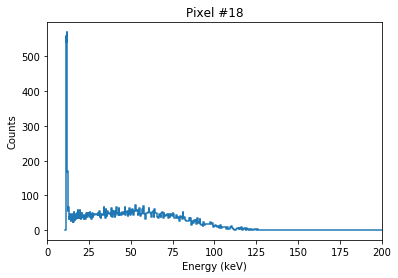

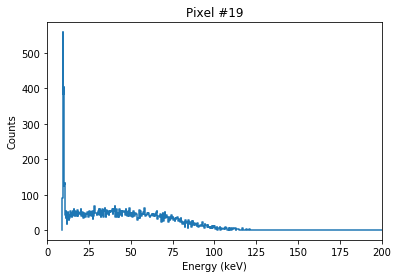

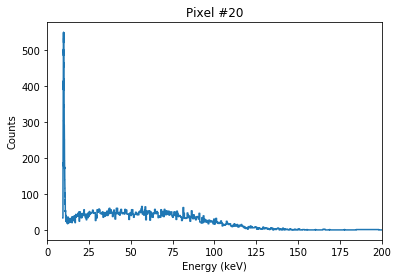

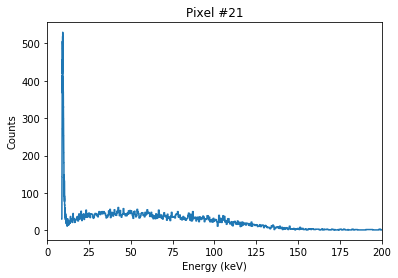

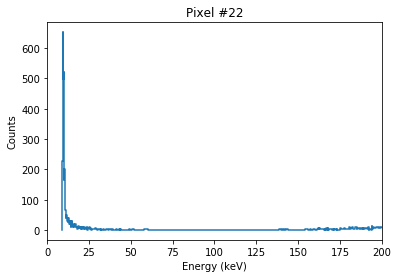

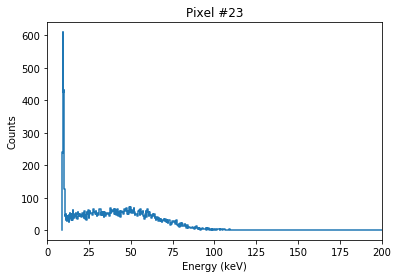

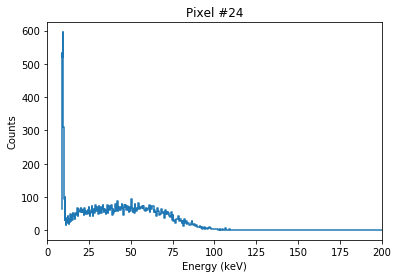

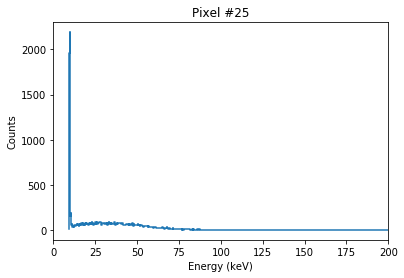

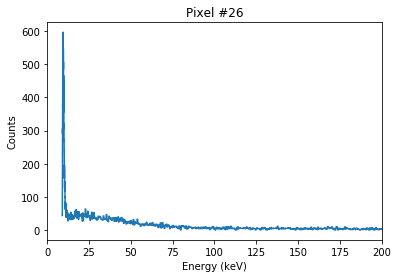

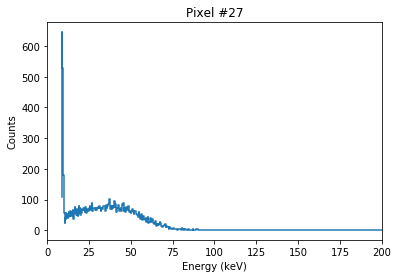

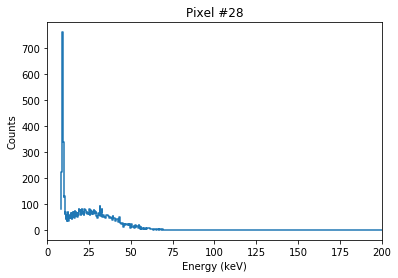

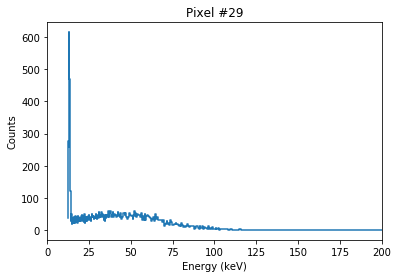

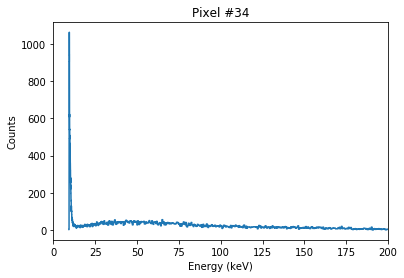

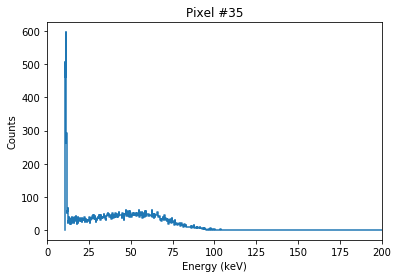

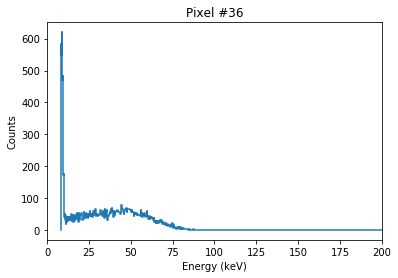

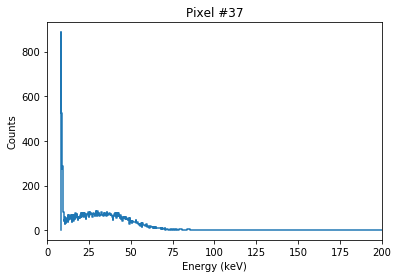

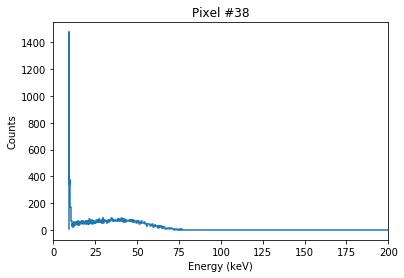

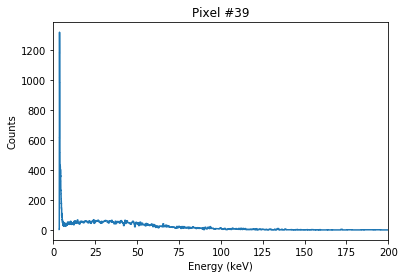

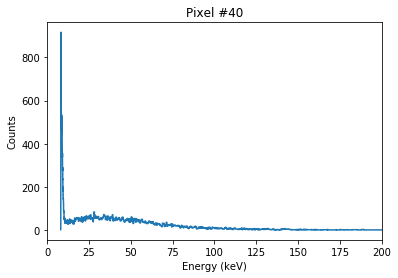

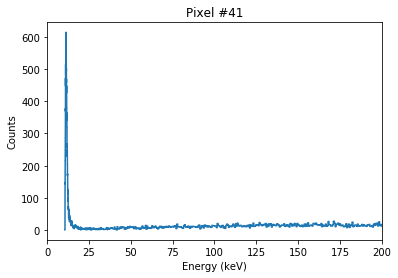

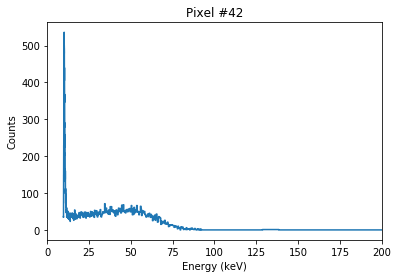

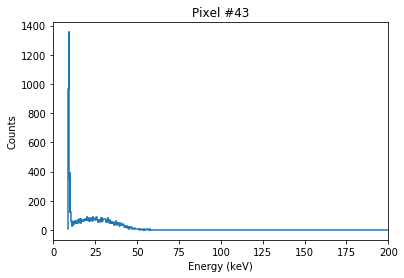

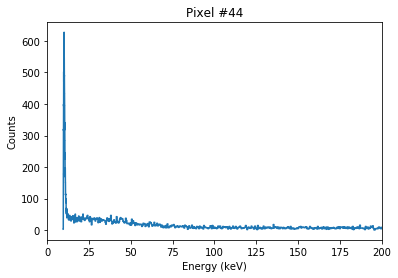

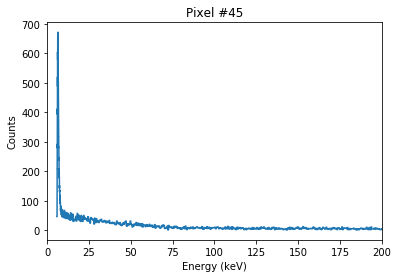

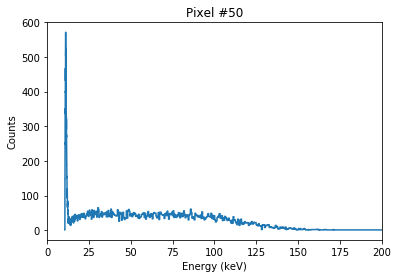

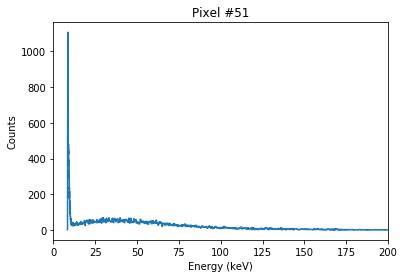

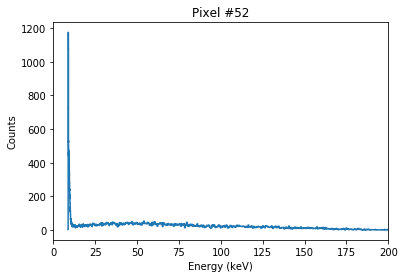

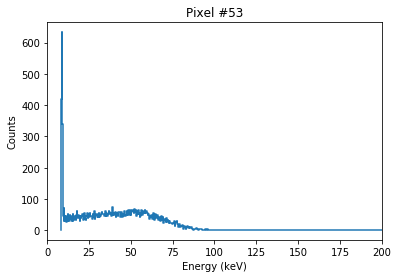

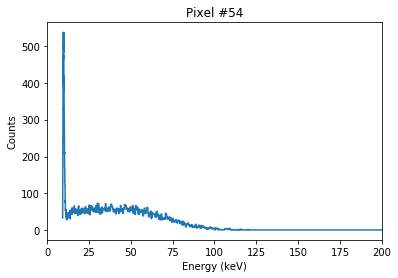

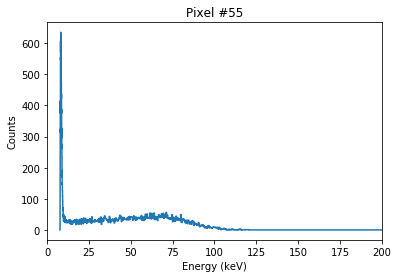

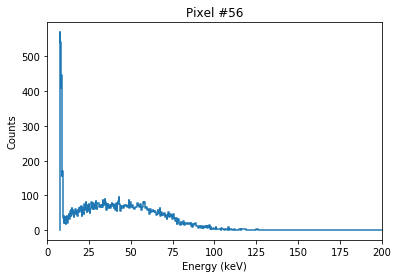

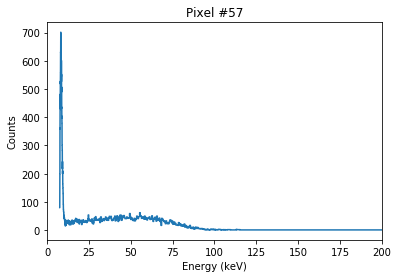

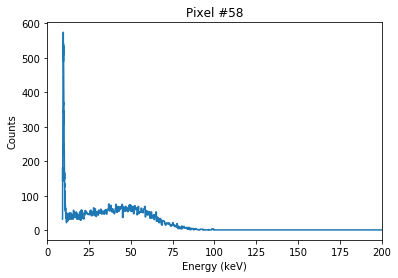

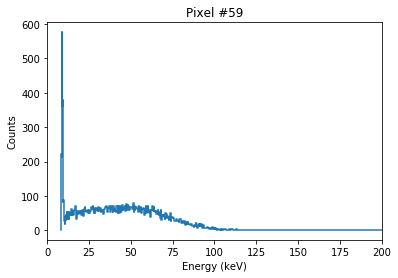

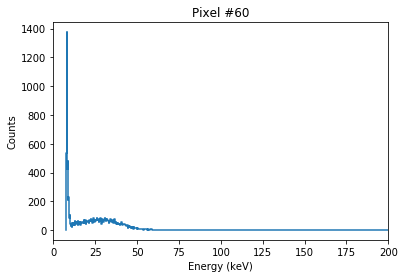

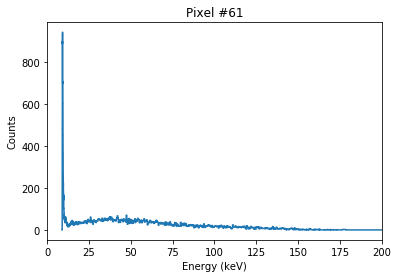

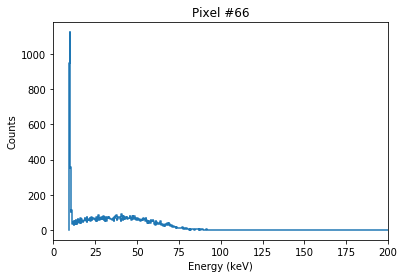

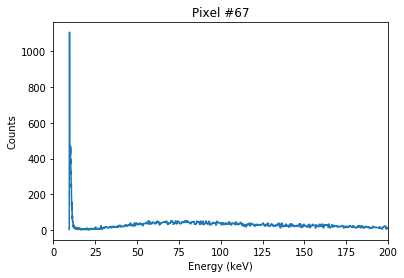

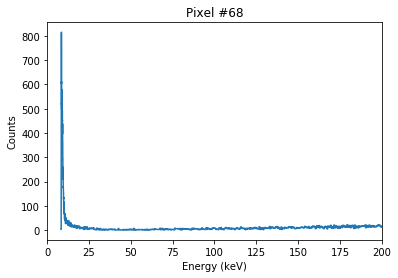

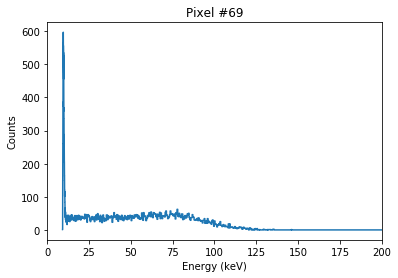

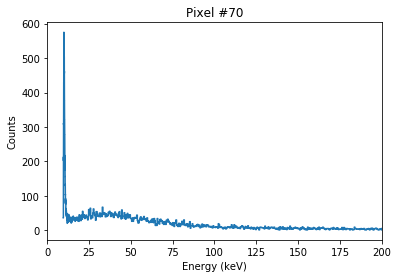

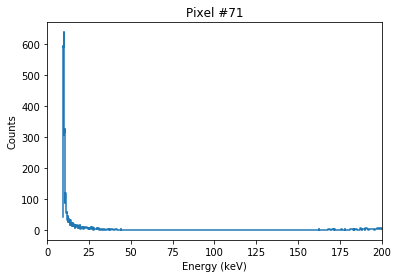

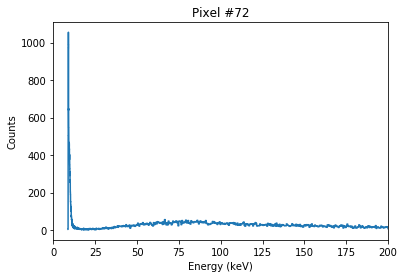

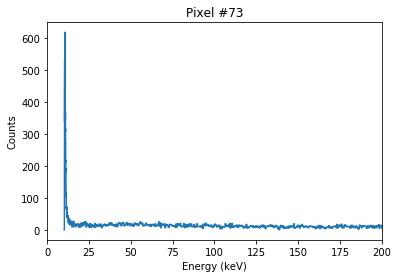

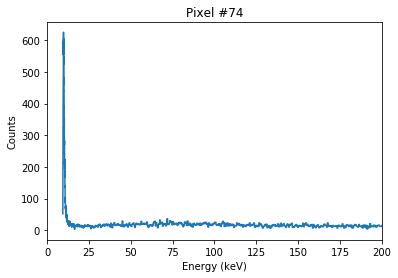

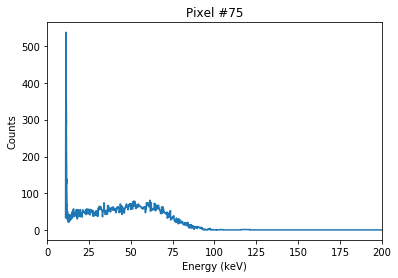

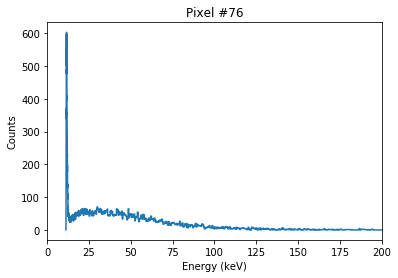

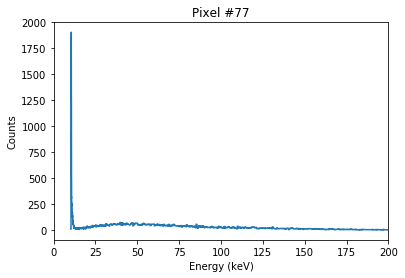

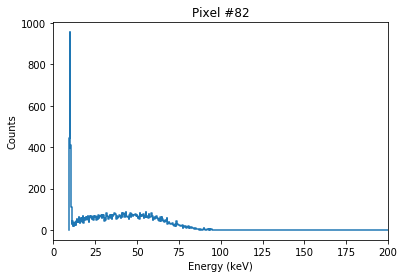

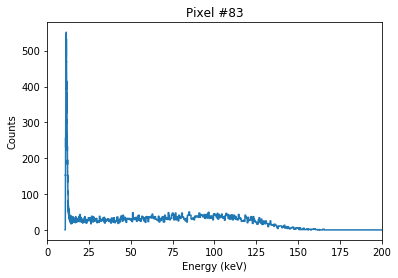

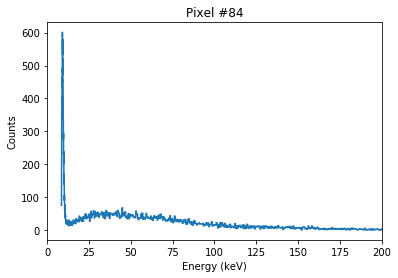

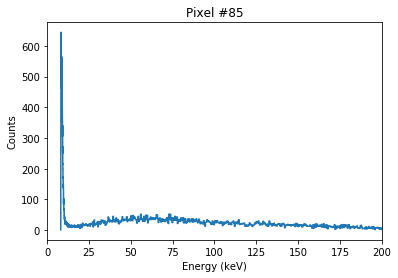

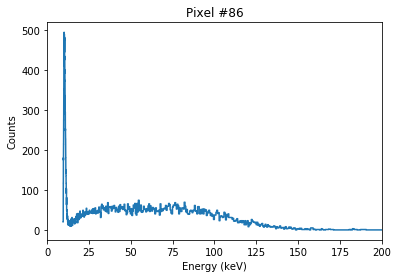

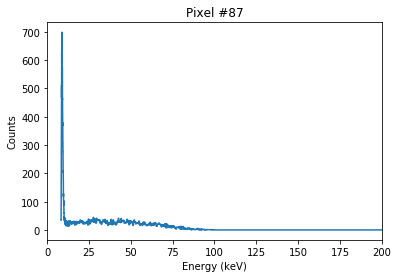

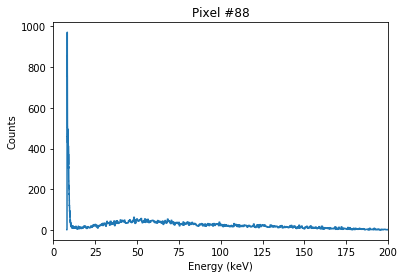

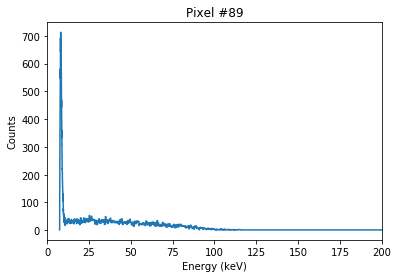

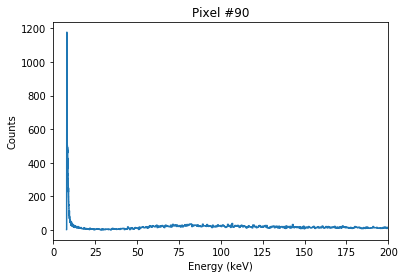

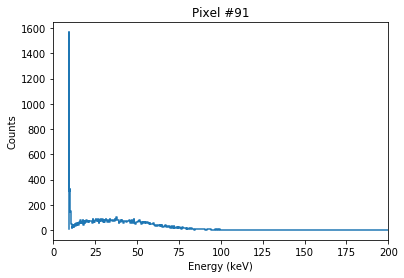

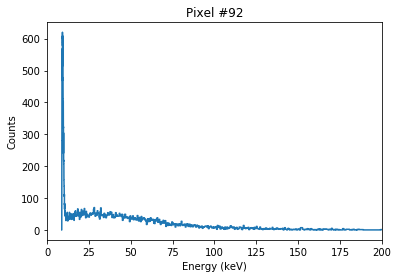

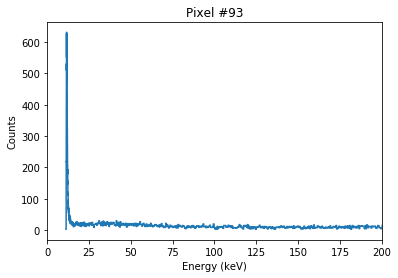

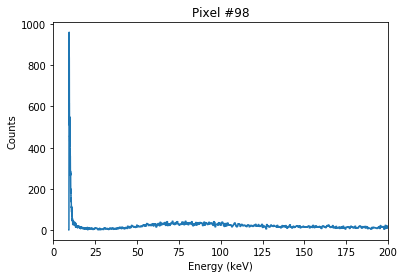

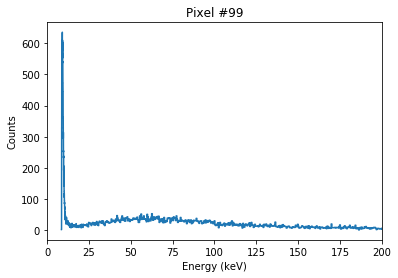

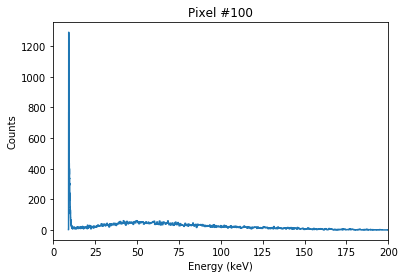

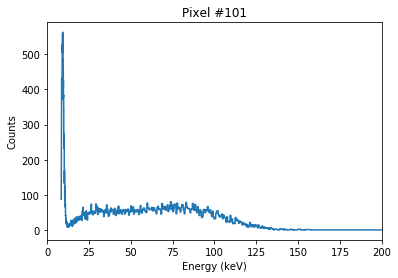

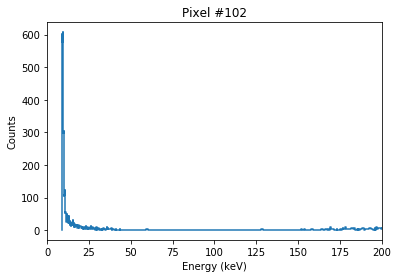

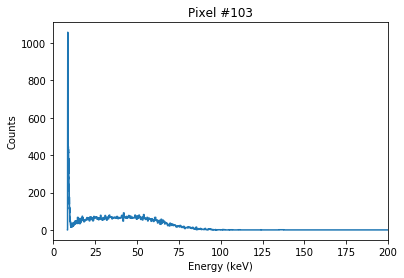

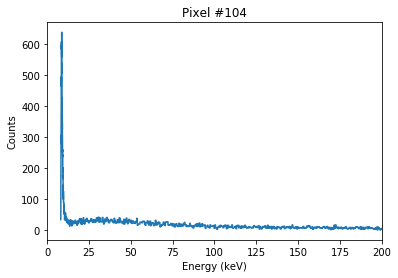

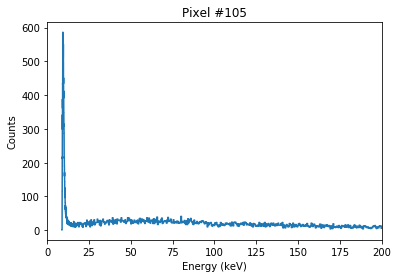

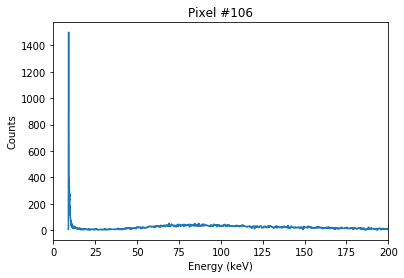

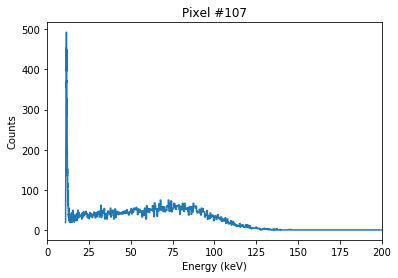

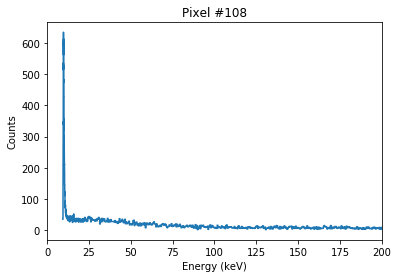

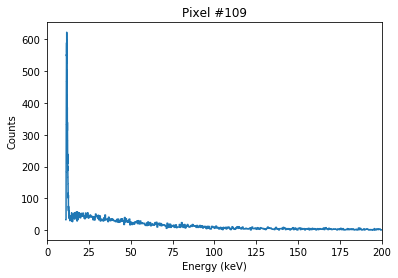

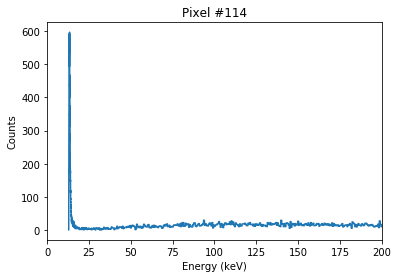

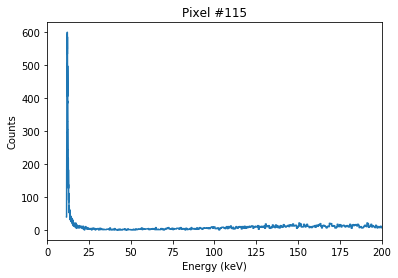

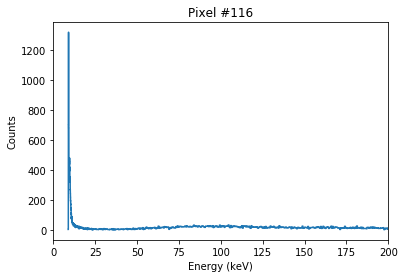

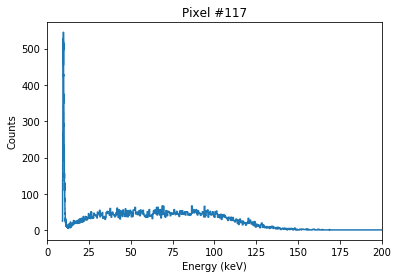

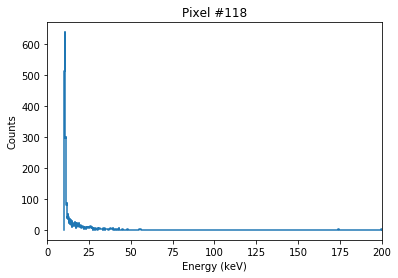

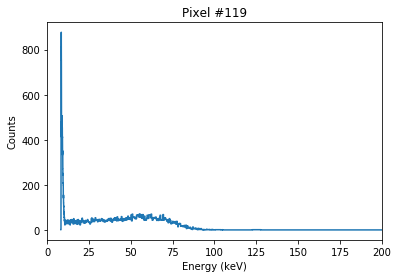

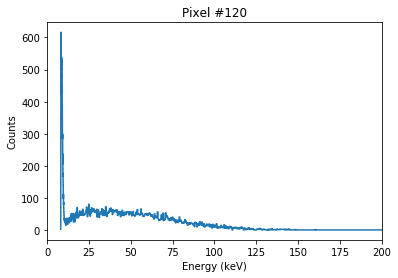

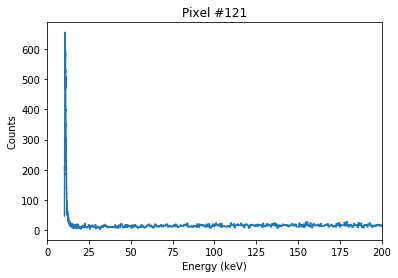

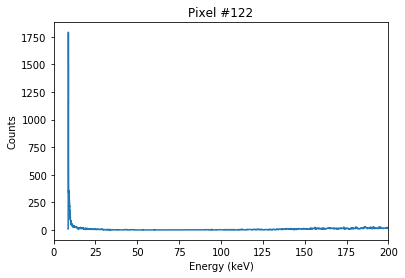

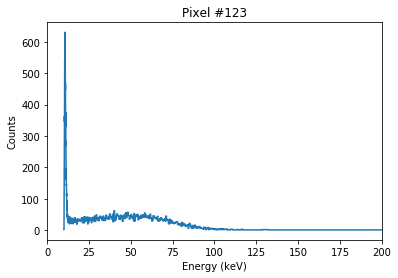

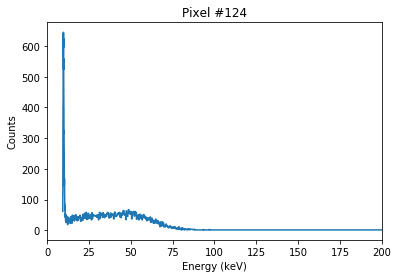

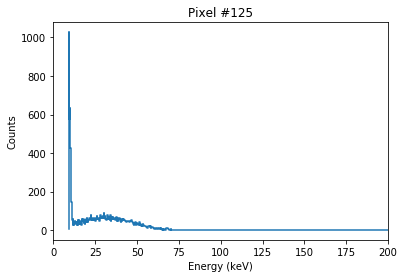

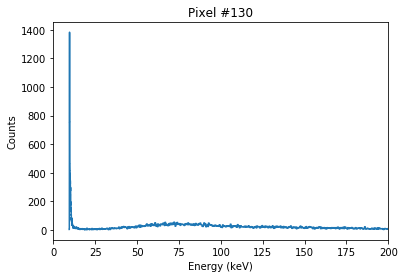

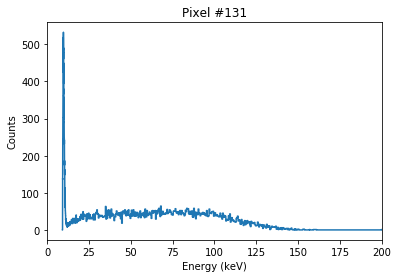

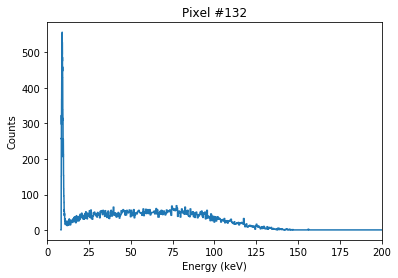

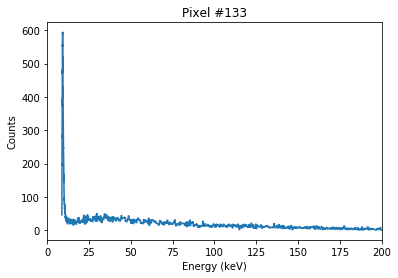

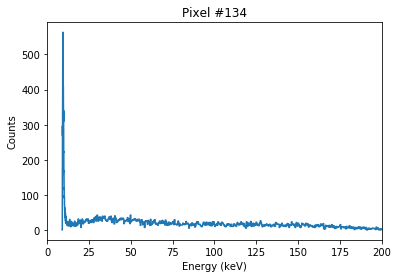

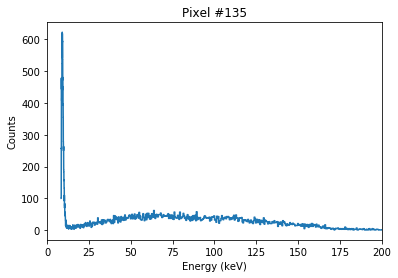

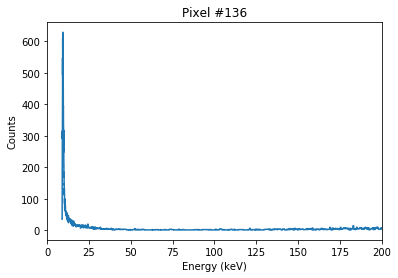

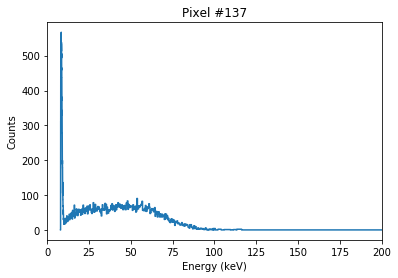

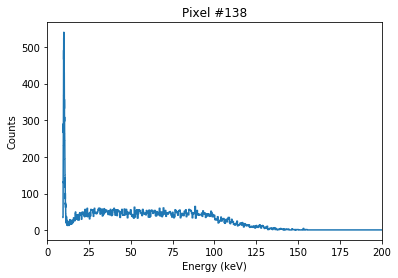

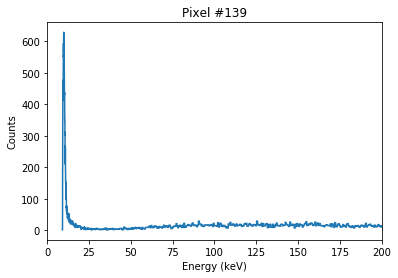

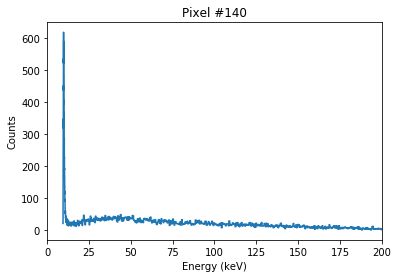

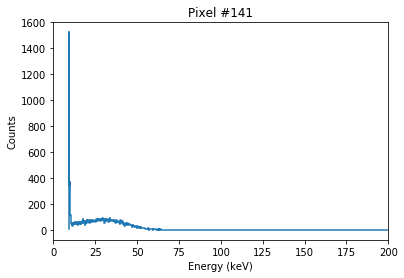

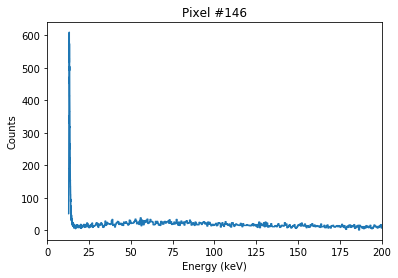

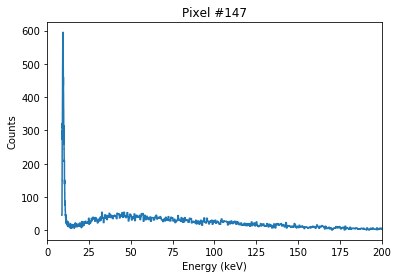

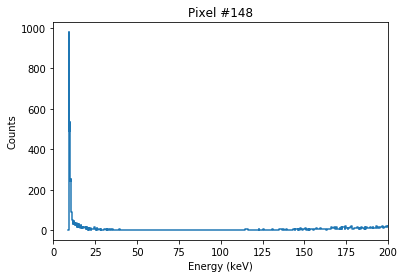

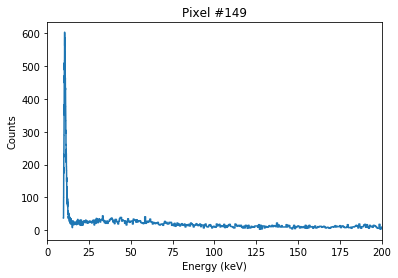

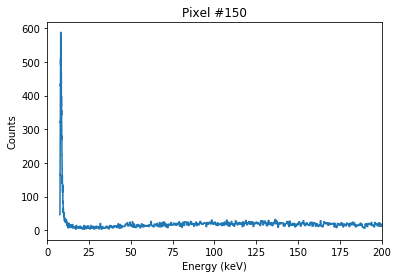

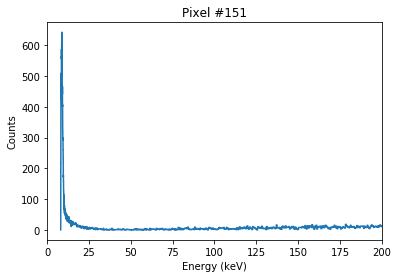

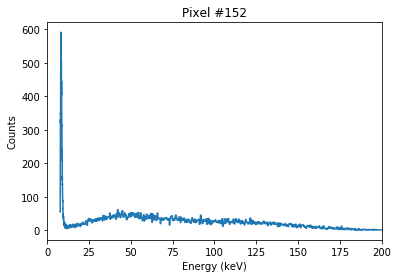

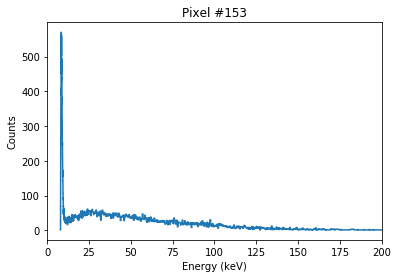

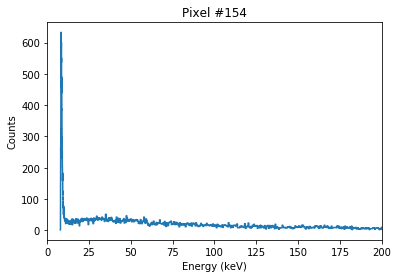

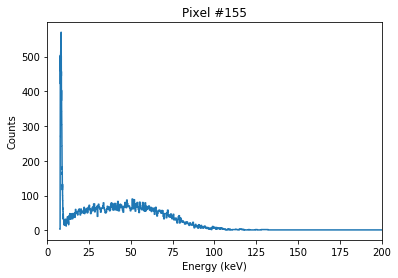

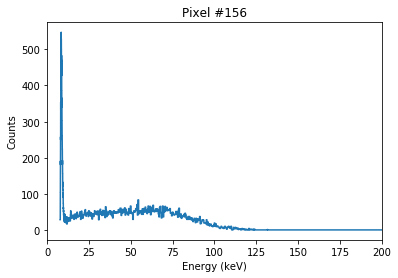

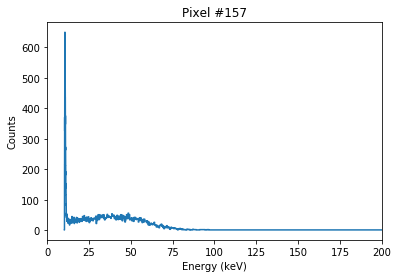

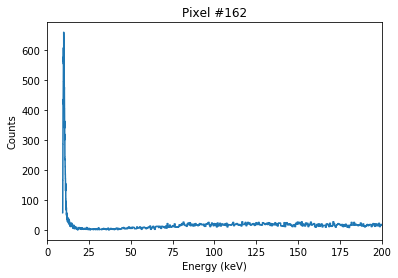

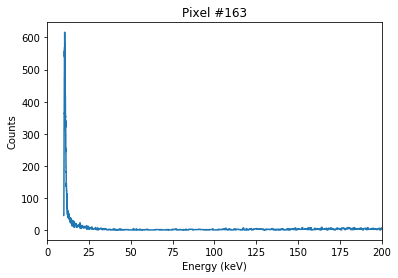

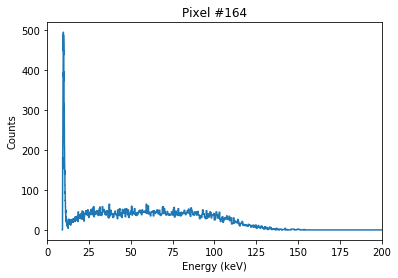

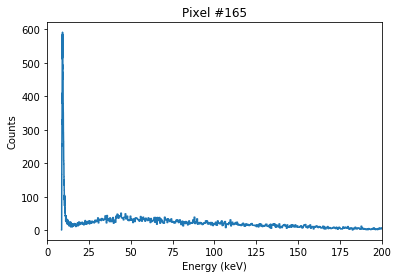

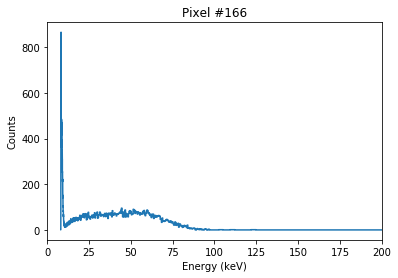

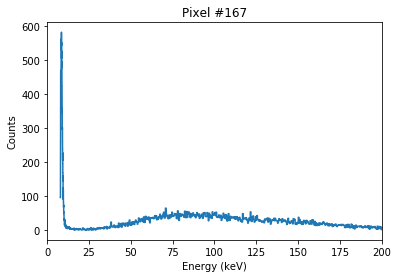

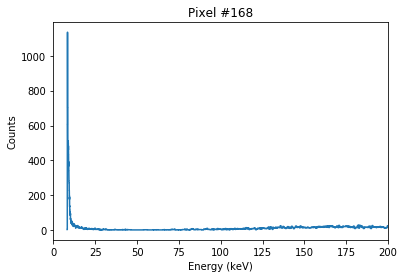

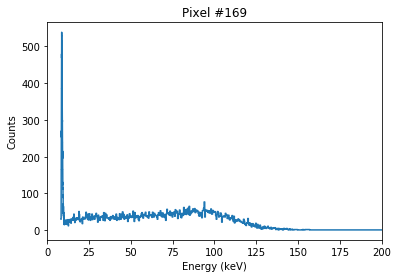

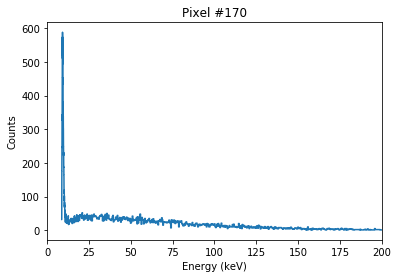

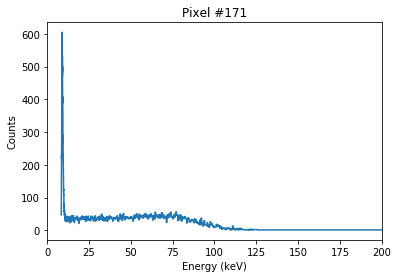

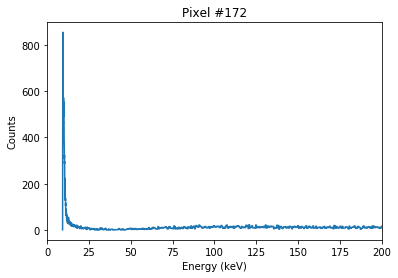

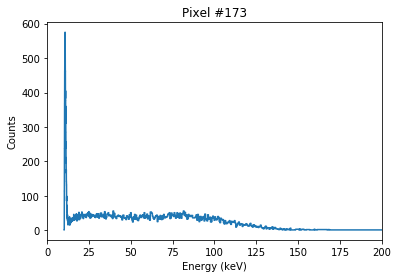

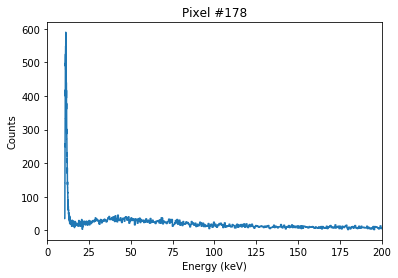

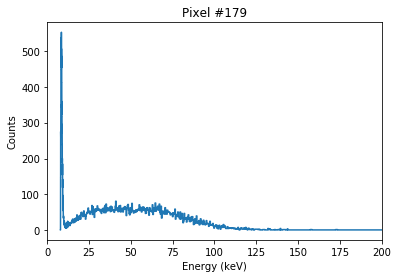

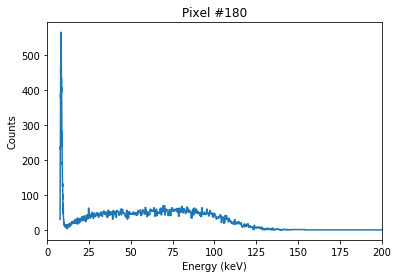

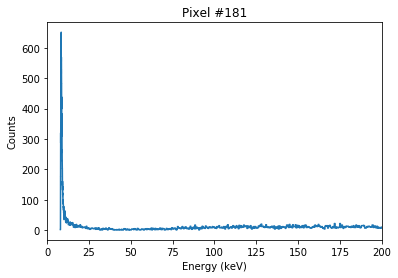

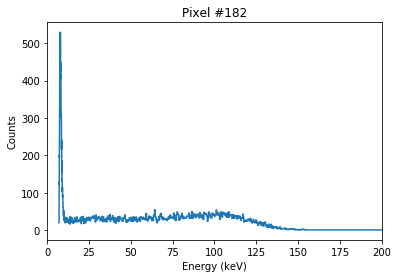

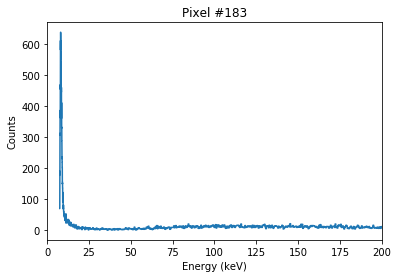

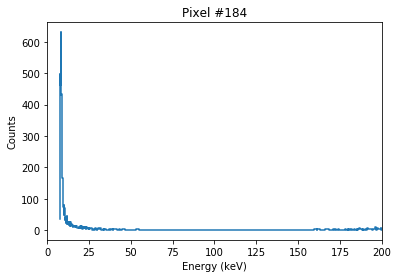

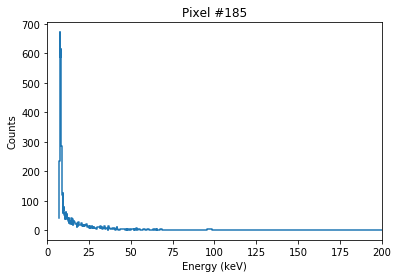

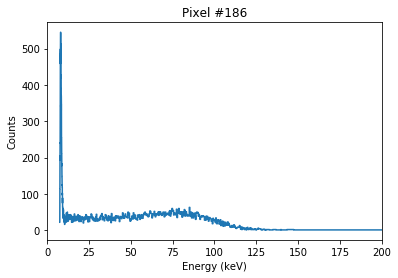

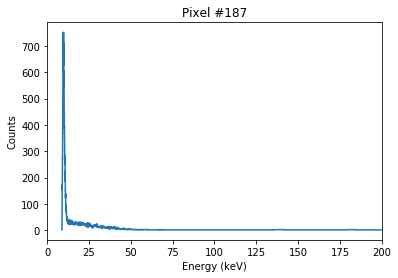

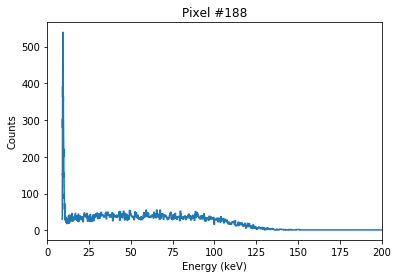

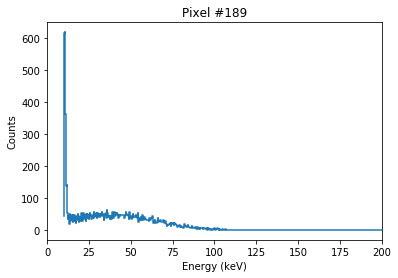

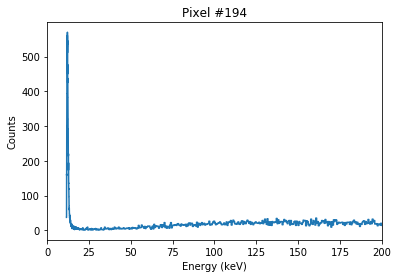

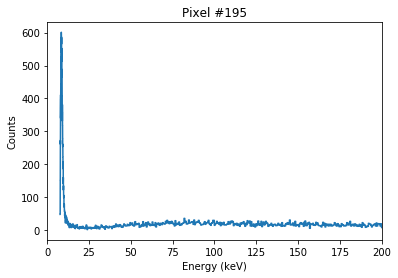

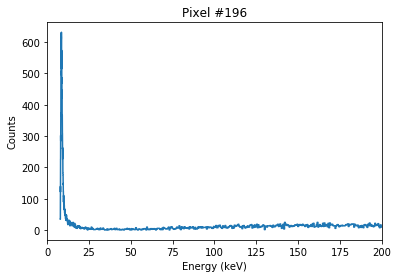

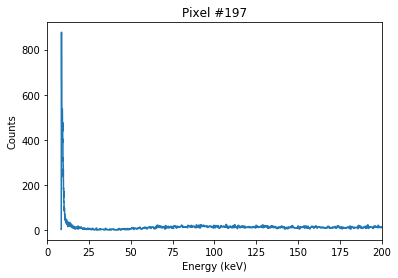

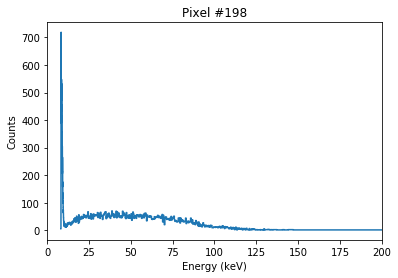

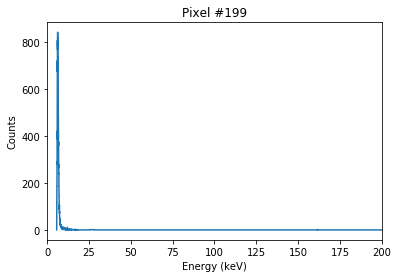

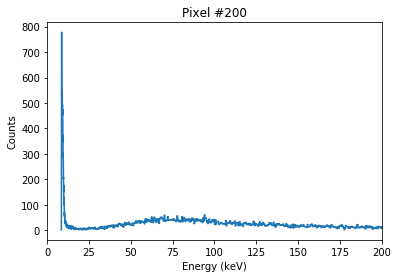

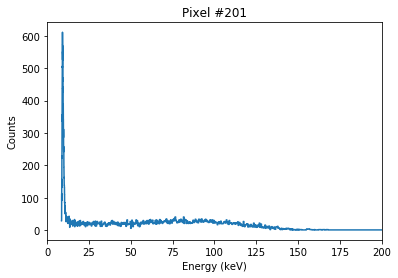

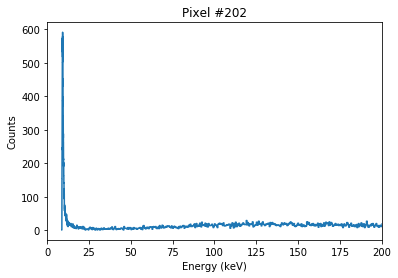

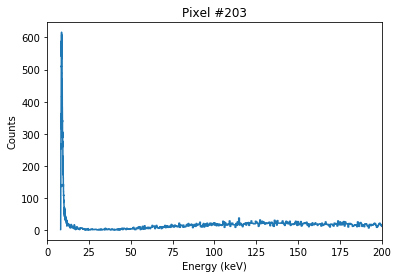

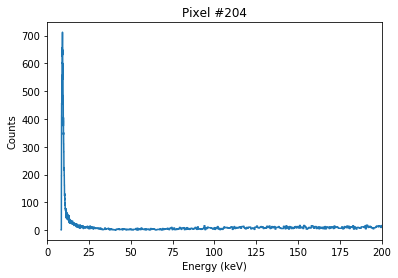

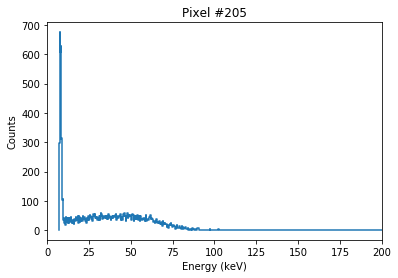

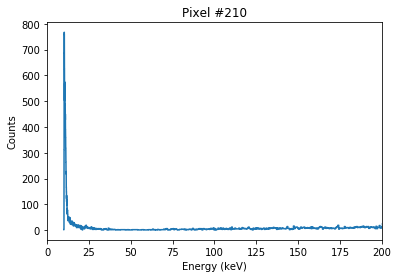

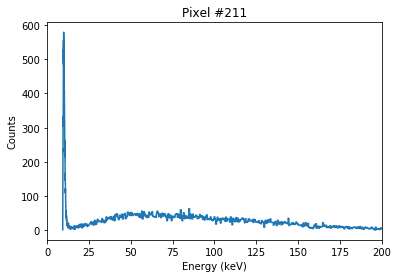

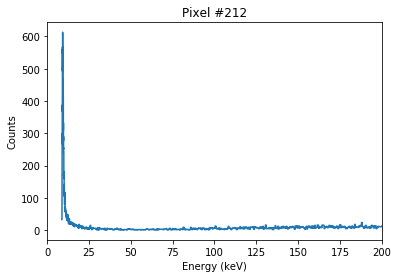

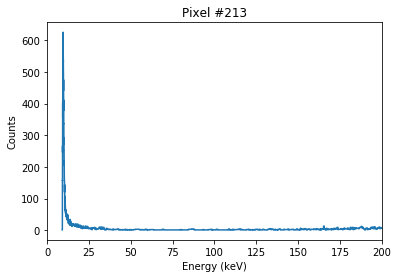

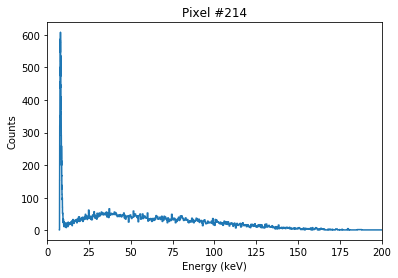

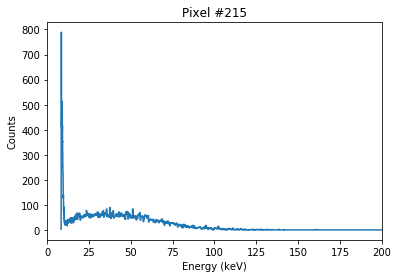

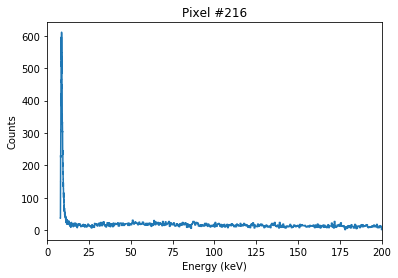

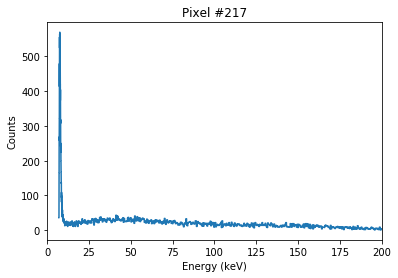

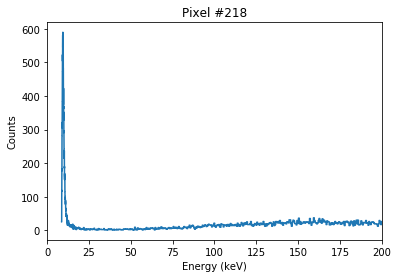

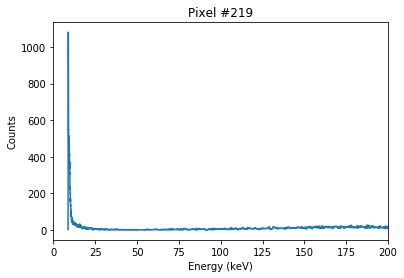

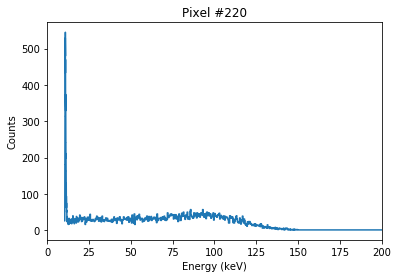

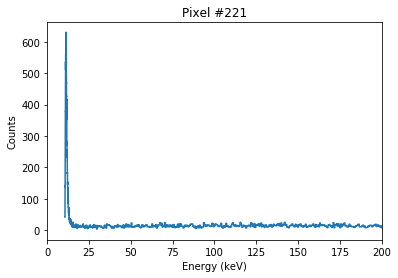

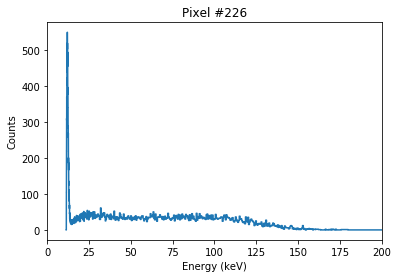

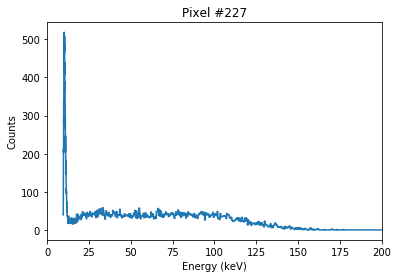

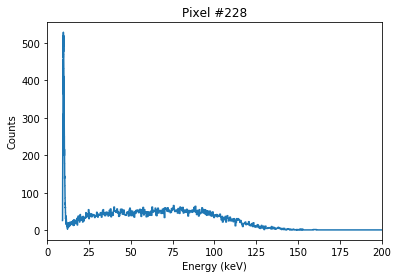

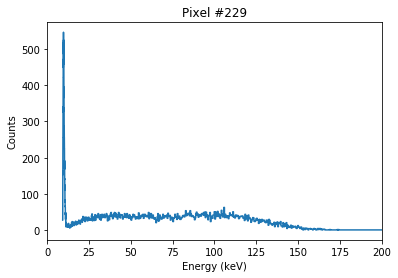

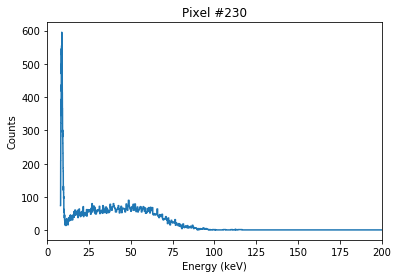

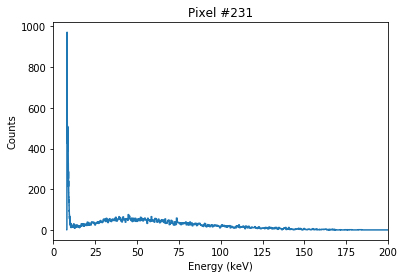

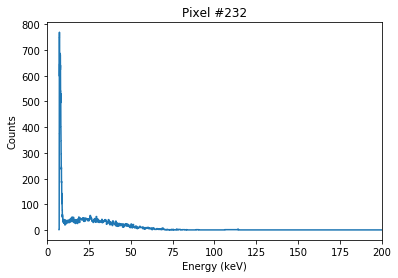

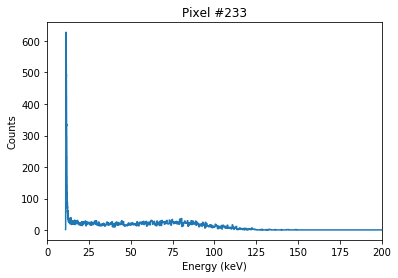

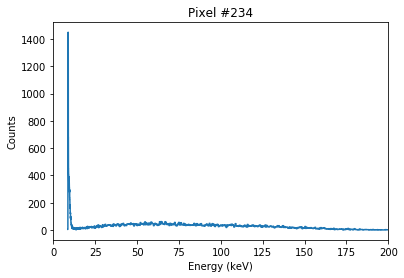

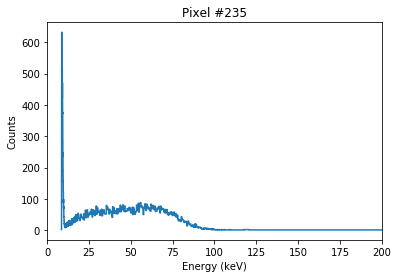

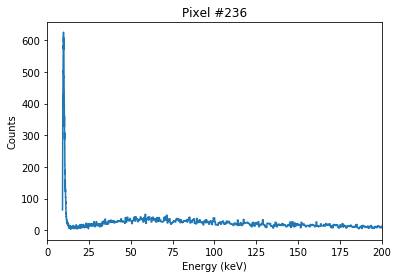

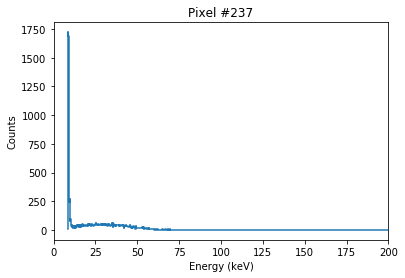

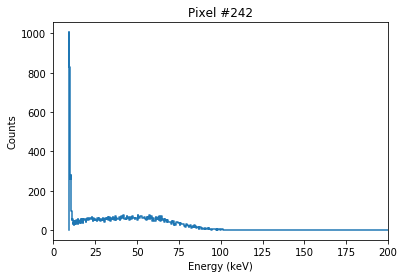

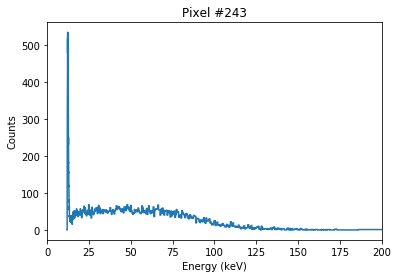

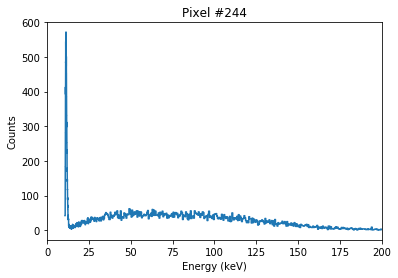

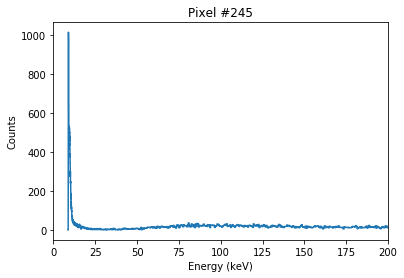

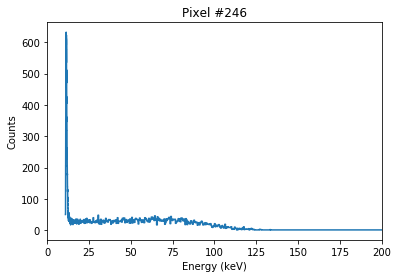

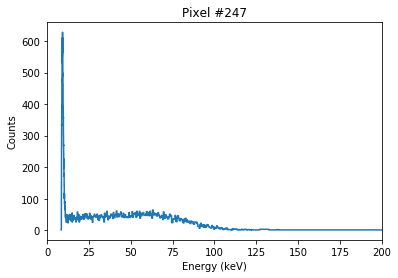

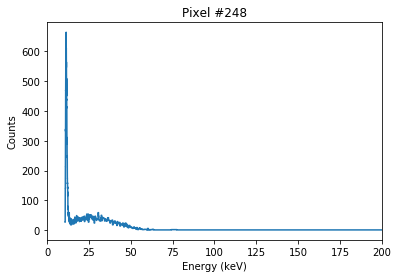

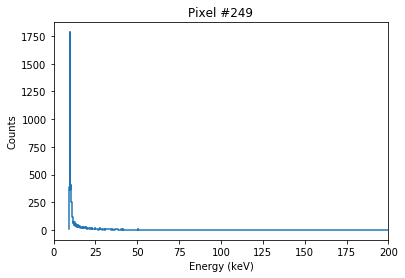

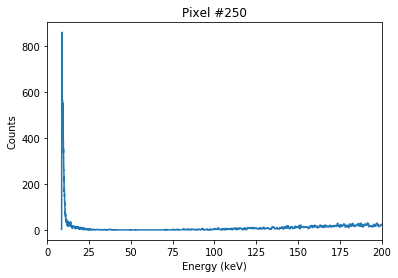

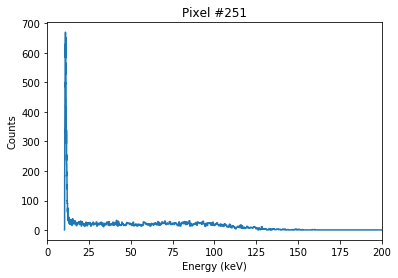

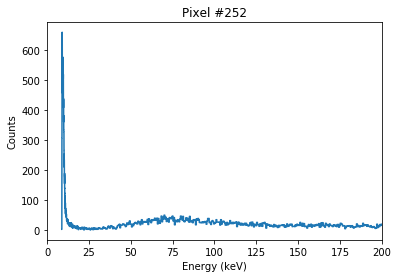

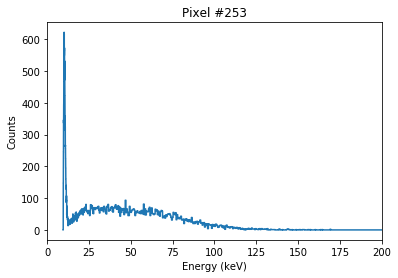

[  9.69313837   9.69313837   9.69313837 ... 742.38156367 761.16451521
 789.58072864]


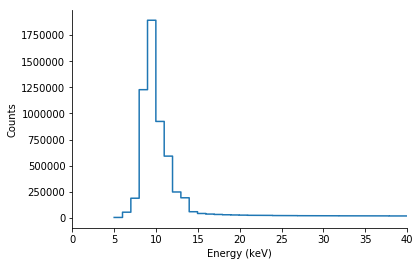

In [37]:
reload(tte)
# tte.getToTtoEnergy(histDict, paramsDict, use_hist=True, plot=True) # , save='/tmp/ToTtoEnergy_AmMo.svg')
tte.getToTtoEnergy(histDict['Slot1'], paramsDict['Slot1'], use_hist=True, plot=True)
plt.xlim(0, 40)
plt.show()

In [30]:
slot = 1
files = [11, 5, 6]
# data = hickle.load('../../dpx_data/ToTMeasurement_60kHz_Slot%d/ToTMeasurement_%d.hck' % (slot, files[slot - 1]))
# data = hickle.load('../../dpx_data/Measurements/DPX22/AmPlexi/ToTMeasurement_28.hck')
dataDict = dataToHist(data['Slot%d' % slot])

KeyboardInterrupt: 

In [27]:
reload(tte)
tte.getToTtoEnergy(dataDict, paramsDict['Slot%d' % slot], use_hist=True, plot=True)

KeyError: 'bins'

## Store to files

In [73]:
hickle.dump(paramsDict, open('../../dpx_data/energyConversion/paramsDict_DPX22_6_109.hck', 'w'))

{'a': -0.2164967954076204, 'c': -93.07962950756063, 'b': 2287.9539225680646, 'h': -0.09356953167888862, 'k': 222.6544402886111, 't': 47.30313834826713}
-0.2164967954076204 2287.9539225680646 -93.07962950756063 47.30313834826713
8.571663251041088
353.24566594731056
66.65312048881157


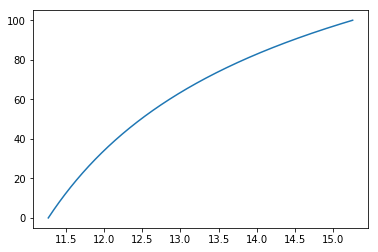

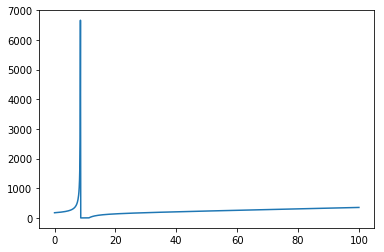

In [19]:
# cPickle.dump(paramsDict, open('testCalibFactors.p', 'wb'))
p = paramsDict[7]
a, b, c, t, h, k = p['a'], p['b'], p['c'], p['t'], p['h'], p['k']
print p
# a /= h
# b = b*h + k
# t *= h
print a, b, c, t

def ToTtoEnergySimple(x, a, b, c, t, h=1, k=0):
    return h * (b + 1./(4 * a) * (2*x + np.pi*c + np.sqrt(16 * a * c * t + (2 * x + np.pi * c)**2))) + k

def EnergyToToTSimple(x, a, b, c, t, h=1, k=0):
    res = np.where(x < b, a*((x - k)/h - b) - c * (np.pi / 2 + t / ((x - k)/h - b)), 0)
    res[res < 0] = 0
    return res

print(b*h + k)
print(EnergyToToTSimple(100, a, b, c, t, h, k))
print(ToTtoEnergySimple(273.5021034056356, a, b, c, t, h, k))

x = np.linspace(0, 100, 1000)
plt.plot(ToTtoEnergySimple(x, a, b, c, t, h, k), x)
plt.show()
plt.plot(x, EnergyToToTSimple(x, a, b, c, t, h, k))